In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
np.random.seed(42)
%matplotlib inline 
import json
import os
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [4]:
#Data Paths
train_dir = './dogbreedidfromcomp/train/'
test_dir = './dogbreedidfromcomp/test/'
#Count/Print train and test samples.

In [5]:
#Read train labels.
labels_dataframe = pd.read_csv('dogbreedidfromcomp/labels.csv')
#Read sample_submission file to be modified by pridected labels.
sample_df = pd.read_csv('dogbreedidfromcomp/sample_submission.csv')
#Incpect labels_dataframe.
labels_dataframe.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
#Create list of alphabetically sorted labels.
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:10]

120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [7]:
#Map each label string to an integer label.
class_to_num = dict(zip(dog_breeds, range(n_classes)))
class_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [8]:
class_to_num['toy_poodle']

110

In [9]:
labels_dataframe['file_name'] = labels_dataframe['id'].apply(lambda x:train_dir+f"{x}.jpg")

In [10]:
labels_dataframe.head(5)['file_name'][0]

'./dogbreedidfromcomp/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [11]:
labels_dataframe.head()

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./dogbreedidfromcomp/train/000bec180eb18c7604d...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./dogbreedidfromcomp/train/001513dfcb2ffafc82c...
2,001cdf01b096e06d78e9e5112d419397,pekinese,./dogbreedidfromcomp/train/001cdf01b096e06d78e...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./dogbreedidfromcomp/train/00214f311d5d2247d5d...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./dogbreedidfromcomp/train/0021f9ceb3235effd7f...


In [12]:
codes = []
for index, data in labels_dataframe.iterrows():
    breed = data['breed']
    codes.append(class_to_num[breed])

codes

[19,
 37,
 85,
 15,
 49,
 10,
 10,
 18,
 7,
 97,
 99,
 113,
 73,
 15,
 79,
 2,
 118,
 89,
 68,
 21,
 38,
 83,
 83,
 10,
 37,
 49,
 106,
 58,
 12,
 26,
 0,
 67,
 55,
 40,
 113,
 114,
 48,
 49,
 19,
 54,
 68,
 58,
 36,
 37,
 0,
 110,
 17,
 68,
 109,
 80,
 2,
 58,
 113,
 58,
 118,
 48,
 0,
 100,
 57,
 66,
 46,
 53,
 8,
 6,
 95,
 90,
 56,
 5,
 46,
 14,
 94,
 77,
 24,
 40,
 63,
 84,
 16,
 24,
 5,
 97,
 42,
 33,
 71,
 115,
 29,
 17,
 93,
 114,
 42,
 57,
 73,
 14,
 88,
 106,
 72,
 40,
 118,
 88,
 68,
 21,
 90,
 65,
 3,
 118,
 40,
 69,
 48,
 74,
 57,
 90,
 93,
 69,
 25,
 37,
 56,
 3,
 24,
 25,
 11,
 15,
 57,
 57,
 42,
 115,
 77,
 4,
 77,
 49,
 90,
 70,
 85,
 27,
 60,
 36,
 31,
 68,
 16,
 56,
 96,
 113,
 54,
 100,
 17,
 70,
 26,
 56,
 1,
 82,
 92,
 69,
 18,
 92,
 113,
 75,
 10,
 43,
 106,
 26,
 83,
 54,
 110,
 97,
 59,
 71,
 73,
 11,
 53,
 96,
 18,
 22,
 111,
 30,
 0,
 44,
 94,
 4,
 113,
 80,
 25,
 33,
 40,
 81,
 103,
 2,
 104,
 12,
 31,
 103,
 39,
 50,
 101,
 84,
 38,
 55,
 0,
 14,
 115,
 17,


In [13]:
y = to_categorical(codes) # encoded our features 
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
# from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as resnet_preprocess
# from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetMobile, preprocess_input as nasnet_preprocess
from keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess
# from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input as resnet_v2_preprocess
from tensorflow.keras.layers import concatenate
from keras.layers import Input,Lambda
from keras.models import Model

input_shape = (224,224,3)
input_layer = Input(shape=input_shape)


#first extractor resnet50v2
preprocessor_resnet = Lambda(resnet_v2_preprocess)(input_layer)
resnet = ResNet50V2(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_resnet)

# second extractor densenet
preprocessor_inception = Lambda(densenet_preprocess)(input_layer)
densenet = DenseNet121(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_inception)
# # Third extractor nasnet
preprocessor_xception = Lambda(nasnet_preprocess)(input_layer)
nasnet = NASNetMobile(weights = 'imagenet',
                                     include_top = False,input_shape = input_shape,pooling ='avg')(preprocessor_xception)

merge = concatenate([resnet,nasnet,densenet])
model = Model(inputs = input_layer, outputs = merge)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                              

In [16]:
model.save('dogbreedidfromcomp/feature_extractor.h5')

C:\Users\chhaa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
v= model.output.shape[1:]
print(v)

(4128,)


In [18]:
# for feature_extraction dataframe must have to contain file_name and  breed columns
def feature_extractor(df):
    img_size = (224,224,3)
    data_size = len(df)
    batch_size = 20
    X = np.zeros([data_size,4128], dtype=np.uint8)
#     y = np.zeros([data_size,120], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,
    x_col = 'file_name', class_mode = None, 
    batch_size=20, shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    i = 0
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        X[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
           break
    return X
        

In [19]:
X = feature_extractor(labels_dataframe)

Found 10222 validated image filenames.


  0%|                                                                                          | 0/512 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


  0%|▏                                                                               | 1/512 [00:09<1:22:48,  9.72s/it]

1/1 [==============================] - 1s 753ms/step


  0%|▎                                                                                 | 2/512 [00:10<38:32,  4.53s/it]

1/1 [==============================] - 1s 843ms/step


  1%|▍                                                                                 | 3/512 [00:11<24:48,  2.92s/it]

1/1 [==============================] - 1s 816ms/step


  1%|▋                                                                                 | 4/512 [00:12<18:07,  2.14s/it]

1/1 [==============================] - 1s 810ms/step


  1%|▊                                                                                 | 5/512 [00:13<14:33,  1.72s/it]

1/1 [==============================] - 1s 863ms/step


  1%|▉                                                                                 | 6/512 [00:14<12:30,  1.48s/it]

1/1 [==============================] - 1s 815ms/step


  1%|█                                                                                 | 7/512 [00:15<11:04,  1.32s/it]

1/1 [==============================] - 1s 864ms/step


  2%|█▎                                                                                | 8/512 [00:16<10:16,  1.22s/it]

1/1 [==============================] - 1s 832ms/step


  2%|█▍                                                                                | 9/512 [00:17<09:40,  1.15s/it]

1/1 [==============================] - 1s 859ms/step


  2%|█▌                                                                               | 10/512 [00:18<09:20,  1.12s/it]

1/1 [==============================] - 1s 754ms/step


  2%|█▋                                                                               | 11/512 [00:19<08:47,  1.05s/it]

1/1 [==============================] - 1s 882ms/step


  2%|█▉                                                                               | 12/512 [00:20<08:47,  1.06s/it]

1/1 [==============================] - 1s 863ms/step


  3%|██                                                                               | 13/512 [00:21<08:37,  1.04s/it]

1/1 [==============================] - 1s 848ms/step


  3%|██▏                                                                              | 14/512 [00:22<08:34,  1.03s/it]

1/1 [==============================] - 1s 805ms/step


  3%|██▎                                                                              | 15/512 [00:23<08:23,  1.01s/it]

1/1 [==============================] - 1s 895ms/step


  3%|██▌                                                                              | 16/512 [00:24<08:25,  1.02s/it]

1/1 [==============================] - 1s 835ms/step


  3%|██▋                                                                              | 17/512 [00:25<08:23,  1.02s/it]

1/1 [==============================] - 1s 768ms/step


  4%|██▊                                                                              | 18/512 [00:26<08:08,  1.01it/s]

1/1 [==============================] - 1s 785ms/step


  4%|███                                                                              | 19/512 [00:27<08:02,  1.02it/s]

1/1 [==============================] - 1s 887ms/step


  4%|███▏                                                                             | 20/512 [00:28<08:06,  1.01it/s]

1/1 [==============================] - 1s 817ms/step


  4%|███▎                                                                             | 21/512 [00:29<08:03,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


  4%|███▍                                                                             | 22/512 [00:30<08:07,  1.00it/s]

1/1 [==============================] - 1s 848ms/step


  4%|███▋                                                                             | 23/512 [00:31<08:12,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


  5%|███▊                                                                             | 24/512 [00:32<08:11,  1.01s/it]

1/1 [==============================] - 1s 831ms/step


  5%|███▉                                                                             | 25/512 [00:33<08:15,  1.02s/it]

1/1 [==============================] - 1s 832ms/step


  5%|████                                                                             | 26/512 [00:34<08:04,  1.00it/s]

1/1 [==============================] - 1s 915ms/step


  5%|████▎                                                                            | 27/512 [00:35<08:14,  1.02s/it]

1/1 [==============================] - 1s 785ms/step


  5%|████▍                                                                            | 28/512 [00:36<07:59,  1.01it/s]

1/1 [==============================] - 1s 872ms/step


  6%|████▌                                                                            | 29/512 [00:37<08:04,  1.00s/it]

1/1 [==============================] - 1s 738ms/step


  6%|████▋                                                                            | 30/512 [00:38<07:48,  1.03it/s]

1/1 [==============================] - 1s 816ms/step


  6%|████▉                                                                            | 31/512 [00:39<07:45,  1.03it/s]

1/1 [==============================] - 1s 895ms/step


  6%|█████                                                                            | 32/512 [00:40<07:54,  1.01it/s]

1/1 [==============================] - 1s 878ms/step


  6%|█████▏                                                                           | 33/512 [00:41<08:02,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


  7%|█████▍                                                                           | 34/512 [00:42<08:05,  1.02s/it]

1/1 [==============================] - 1s 749ms/step


  7%|█████▌                                                                           | 35/512 [00:43<07:44,  1.03it/s]

1/1 [==============================] - 1s 880ms/step


  7%|█████▋                                                                           | 36/512 [00:44<07:52,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


  7%|█████▊                                                                           | 37/512 [00:45<07:52,  1.00it/s]

1/1 [==============================] - 1s 879ms/step


  7%|██████                                                                           | 38/512 [00:46<07:55,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


  8%|██████▏                                                                          | 39/512 [00:47<08:03,  1.02s/it]

1/1 [==============================] - 1s 891ms/step


  8%|██████▎                                                                          | 40/512 [00:48<08:04,  1.03s/it]

1/1 [==============================] - 1s 738ms/step


  8%|██████▍                                                                          | 41/512 [00:49<07:38,  1.03it/s]

1/1 [==============================] - 1s 894ms/step


  8%|██████▋                                                                          | 42/512 [00:50<07:50,  1.00s/it]

1/1 [==============================] - 1s 850ms/step


  8%|██████▊                                                                          | 43/512 [00:51<07:54,  1.01s/it]

1/1 [==============================] - 1s 786ms/step


  9%|██████▉                                                                          | 44/512 [00:52<07:46,  1.00it/s]

1/1 [==============================] - 1s 884ms/step


  9%|███████                                                                          | 45/512 [00:53<07:51,  1.01s/it]

1/1 [==============================] - 1s 910ms/step


  9%|███████▎                                                                         | 46/512 [00:54<07:58,  1.03s/it]

1/1 [==============================] - 1s 832ms/step


  9%|███████▍                                                                         | 47/512 [00:55<07:54,  1.02s/it]

1/1 [==============================] - 1s 848ms/step


  9%|███████▌                                                                         | 48/512 [00:56<07:51,  1.02s/it]

1/1 [==============================] - 1s 737ms/step


 10%|███████▊                                                                         | 49/512 [00:57<07:33,  1.02it/s]

1/1 [==============================] - 1s 886ms/step


 10%|███████▉                                                                         | 50/512 [00:58<07:39,  1.01it/s]

1/1 [==============================] - 1s 833ms/step


 10%|████████                                                                         | 51/512 [00:59<07:39,  1.00it/s]

1/1 [==============================] - 1s 738ms/step


 10%|████████▏                                                                        | 52/512 [01:00<07:22,  1.04it/s]

1/1 [==============================] - 1s 737ms/step


 10%|████████▍                                                                        | 53/512 [01:01<07:10,  1.07it/s]

1/1 [==============================] - 1s 864ms/step


 11%|████████▌                                                                        | 54/512 [01:02<07:18,  1.04it/s]

1/1 [==============================] - 1s 869ms/step


 11%|████████▋                                                                        | 55/512 [01:03<07:27,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 11%|████████▊                                                                        | 56/512 [01:04<07:27,  1.02it/s]

1/1 [==============================] - 1s 815ms/step


 11%|█████████                                                                        | 57/512 [01:05<07:21,  1.03it/s]

1/1 [==============================] - 1s 880ms/step


 11%|█████████▏                                                                       | 58/512 [01:06<07:27,  1.02it/s]

1/1 [==============================] - 1s 849ms/step


 12%|█████████▎                                                                       | 59/512 [01:07<07:24,  1.02it/s]

1/1 [==============================] - 1s 741ms/step


 12%|█████████▍                                                                       | 60/512 [01:08<07:12,  1.05it/s]

1/1 [==============================] - 1s 769ms/step


 12%|█████████▋                                                                       | 61/512 [01:09<07:05,  1.06it/s]

1/1 [==============================] - 1s 850ms/step


 12%|█████████▊                                                                       | 62/512 [01:10<07:11,  1.04it/s]

1/1 [==============================] - 1s 895ms/step


 12%|█████████▉                                                                       | 63/512 [01:11<07:20,  1.02it/s]

1/1 [==============================] - 1s 864ms/step


 12%|██████████▏                                                                      | 64/512 [01:12<07:22,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 13%|██████████▎                                                                      | 65/512 [01:13<07:23,  1.01it/s]

1/1 [==============================] - 1s 852ms/step


 13%|██████████▍                                                                      | 66/512 [01:14<07:25,  1.00it/s]

1/1 [==============================] - 1s 879ms/step


 13%|██████████▌                                                                      | 67/512 [01:15<07:29,  1.01s/it]

1/1 [==============================] - 1s 722ms/step


 13%|██████████▊                                                                      | 68/512 [01:16<07:11,  1.03it/s]

1/1 [==============================] - 1s 847ms/step


 13%|██████████▉                                                                      | 69/512 [01:17<07:12,  1.02it/s]

1/1 [==============================] - 1s 892ms/step


 14%|███████████                                                                      | 70/512 [01:18<07:20,  1.00it/s]

1/1 [==============================] - 1s 800ms/step


 14%|███████████▏                                                                     | 71/512 [01:19<07:14,  1.02it/s]

1/1 [==============================] - 1s 895ms/step


 14%|███████████▍                                                                     | 72/512 [01:20<07:22,  1.01s/it]

1/1 [==============================] - 1s 894ms/step


 14%|███████████▌                                                                     | 73/512 [01:21<07:25,  1.02s/it]

1/1 [==============================] - 1s 911ms/step


 14%|███████████▋                                                                     | 74/512 [01:22<07:31,  1.03s/it]

1/1 [==============================] - 1s 863ms/step


 15%|███████████▊                                                                     | 75/512 [01:23<07:29,  1.03s/it]

1/1 [==============================] - 1s 894ms/step


 15%|████████████                                                                     | 76/512 [01:24<07:29,  1.03s/it]

1/1 [==============================] - 1s 754ms/step


 15%|████████████▏                                                                    | 77/512 [01:25<07:14,  1.00it/s]

1/1 [==============================] - 1s 832ms/step


 15%|████████████▎                                                                    | 78/512 [01:26<07:10,  1.01it/s]

1/1 [==============================] - 1s 879ms/step


 15%|████████████▍                                                                    | 79/512 [01:27<07:17,  1.01s/it]

1/1 [==============================] - 1s 889ms/step


 16%|████████████▋                                                                    | 80/512 [01:28<07:18,  1.02s/it]

1/1 [==============================] - 1s 879ms/step


 16%|████████████▊                                                                    | 81/512 [01:29<07:18,  1.02s/it]

1/1 [==============================] - 1s 833ms/step


 16%|████████████▉                                                                    | 82/512 [01:30<07:13,  1.01s/it]

1/1 [==============================] - 1s 881ms/step


 16%|█████████████▏                                                                   | 83/512 [01:31<07:14,  1.01s/it]

1/1 [==============================] - 1s 738ms/step


 16%|█████████████▎                                                                   | 84/512 [01:32<07:02,  1.01it/s]

1/1 [==============================] - 1s 817ms/step


 17%|█████████████▍                                                                   | 85/512 [01:33<06:57,  1.02it/s]

1/1 [==============================] - 1s 847ms/step


 17%|█████████████▌                                                                   | 86/512 [01:34<07:00,  1.01it/s]

1/1 [==============================] - 1s 879ms/step


 17%|█████████████▊                                                                   | 87/512 [01:35<07:05,  1.00s/it]

1/1 [==============================] - 1s 865ms/step


 17%|█████████████▉                                                                   | 88/512 [01:36<07:07,  1.01s/it]

1/1 [==============================] - 1s 894ms/step


 17%|██████████████                                                                   | 89/512 [01:37<07:13,  1.03s/it]

1/1 [==============================] - 1s 847ms/step


 18%|██████████████▏                                                                  | 90/512 [01:38<07:09,  1.02s/it]

1/1 [==============================] - 1s 833ms/step


 18%|██████████████▍                                                                  | 91/512 [01:39<07:03,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


 18%|██████████████▌                                                                  | 92/512 [01:40<07:02,  1.01s/it]

1/1 [==============================] - 1s 860ms/step


 18%|██████████████▋                                                                  | 93/512 [01:41<07:03,  1.01s/it]

1/1 [==============================] - 1s 844ms/step


 18%|██████████████▊                                                                  | 94/512 [01:42<07:00,  1.01s/it]

1/1 [==============================] - 1s 816ms/step


 19%|███████████████                                                                  | 95/512 [01:43<06:52,  1.01it/s]

1/1 [==============================] - 1s 753ms/step


 19%|███████████████▏                                                                 | 96/512 [01:44<06:39,  1.04it/s]

1/1 [==============================] - 1s 879ms/step


 19%|███████████████▎                                                                 | 97/512 [01:45<06:46,  1.02it/s]

1/1 [==============================] - 1s 895ms/step


 19%|███████████████▌                                                                 | 98/512 [01:46<06:52,  1.00it/s]

1/1 [==============================] - 1s 784ms/step


 19%|███████████████▋                                                                 | 99/512 [01:47<06:44,  1.02it/s]

1/1 [==============================] - 1s 880ms/step


 20%|███████████████▋                                                                | 100/512 [01:48<06:53,  1.00s/it]

1/1 [==============================] - 1s 862ms/step


 20%|███████████████▊                                                                | 101/512 [01:49<06:56,  1.01s/it]

1/1 [==============================] - 1s 880ms/step


 20%|███████████████▉                                                                | 102/512 [01:50<06:57,  1.02s/it]

1/1 [==============================] - 1s 864ms/step


 20%|████████████████                                                                | 103/512 [01:51<06:55,  1.02s/it]

1/1 [==============================] - 1s 879ms/step


 20%|████████████████▎                                                               | 104/512 [01:52<06:57,  1.02s/it]

1/1 [==============================] - 1s 722ms/step


 21%|████████████████▍                                                               | 105/512 [01:53<06:40,  1.02it/s]

1/1 [==============================] - 1s 769ms/step


 21%|████████████████▌                                                               | 106/512 [01:54<06:30,  1.04it/s]

1/1 [==============================] - 1s 769ms/step


 21%|████████████████▋                                                               | 107/512 [01:55<06:25,  1.05it/s]

1/1 [==============================] - 1s 863ms/step


 21%|████████████████▉                                                               | 108/512 [01:56<06:32,  1.03it/s]

1/1 [==============================] - 1s 832ms/step


 21%|█████████████████                                                               | 109/512 [01:57<06:31,  1.03it/s]

1/1 [==============================] - 1s 847ms/step


 21%|█████████████████▏                                                              | 110/512 [01:58<06:34,  1.02it/s]

1/1 [==============================] - 1s 810ms/step


 22%|█████████████████▎                                                              | 111/512 [01:58<06:30,  1.03it/s]

1/1 [==============================] - 1s 895ms/step


 22%|█████████████████▌                                                              | 112/512 [01:59<06:36,  1.01it/s]

1/1 [==============================] - 1s 817ms/step


 22%|█████████████████▋                                                              | 113/512 [02:00<06:31,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 22%|█████████████████▊                                                              | 114/512 [02:01<06:31,  1.02it/s]

1/1 [==============================] - 1s 738ms/step


 22%|█████████████████▉                                                              | 115/512 [02:02<06:18,  1.05it/s]

1/1 [==============================] - 1s 810ms/step


 23%|██████████████████▏                                                             | 116/512 [02:03<06:20,  1.04it/s]

1/1 [==============================] - 1s 785ms/step


 23%|██████████████████▎                                                             | 117/512 [02:04<06:15,  1.05it/s]

1/1 [==============================] - 1s 753ms/step


 23%|██████████████████▍                                                             | 118/512 [02:05<06:11,  1.06it/s]

1/1 [==============================] - 1s 772ms/step


 23%|██████████████████▌                                                             | 119/512 [02:06<06:08,  1.07it/s]

1/1 [==============================] - 1s 879ms/step


 23%|██████████████████▊                                                             | 120/512 [02:07<06:15,  1.04it/s]

1/1 [==============================] - 1s 840ms/step


 24%|██████████████████▉                                                             | 121/512 [02:08<06:21,  1.03it/s]

1/1 [==============================] - 1s 863ms/step


 24%|███████████████████                                                             | 122/512 [02:09<06:23,  1.02it/s]

1/1 [==============================] - 1s 878ms/step


 24%|███████████████████▏                                                            | 123/512 [02:10<06:28,  1.00it/s]

1/1 [==============================] - 1s 801ms/step


 24%|███████████████████▍                                                            | 124/512 [02:11<06:23,  1.01it/s]

1/1 [==============================] - 1s 868ms/step


 24%|███████████████████▌                                                            | 125/512 [02:12<06:33,  1.02s/it]

1/1 [==============================] - 1s 824ms/step


 25%|███████████████████▋                                                            | 126/512 [02:13<06:24,  1.00it/s]

1/1 [==============================] - 1s 816ms/step


 25%|███████████████████▊                                                            | 127/512 [02:14<06:17,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 25%|████████████████████                                                            | 128/512 [02:15<06:15,  1.02it/s]

1/1 [==============================] - 1s 876ms/step


 25%|████████████████████▏                                                           | 129/512 [02:16<06:19,  1.01it/s]

1/1 [==============================] - 1s 870ms/step


 25%|████████████████████▎                                                           | 130/512 [02:17<06:23,  1.00s/it]

1/1 [==============================] - 1s 764ms/step


 26%|████████████████████▍                                                           | 131/512 [02:18<06:11,  1.03it/s]

1/1 [==============================] - 1s 878ms/step


 26%|████████████████████▋                                                           | 132/512 [02:19<06:20,  1.00s/it]

1/1 [==============================] - 1s 784ms/step


 26%|████████████████████▊                                                           | 133/512 [02:20<06:11,  1.02it/s]

1/1 [==============================] - 1s 848ms/step


 26%|████████████████████▉                                                           | 134/512 [02:21<06:14,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 26%|█████████████████████                                                           | 135/512 [02:22<06:15,  1.00it/s]

1/1 [==============================] - 1s 763ms/step


 27%|█████████████████████▎                                                          | 136/512 [02:23<06:03,  1.03it/s]

1/1 [==============================] - 1s 864ms/step


 27%|█████████████████████▍                                                          | 137/512 [02:24<06:10,  1.01it/s]

1/1 [==============================] - 1s 895ms/step


 27%|█████████████████████▌                                                          | 138/512 [02:25<06:14,  1.00s/it]

1/1 [==============================] - 1s 894ms/step


 27%|█████████████████████▋                                                          | 139/512 [02:26<06:17,  1.01s/it]

1/1 [==============================] - 1s 736ms/step


 27%|█████████████████████▉                                                          | 140/512 [02:27<06:01,  1.03it/s]

1/1 [==============================] - 1s 731ms/step


 28%|██████████████████████                                                          | 141/512 [02:28<05:51,  1.06it/s]

1/1 [==============================] - 1s 722ms/step


 28%|██████████████████████▏                                                         | 142/512 [02:29<05:41,  1.08it/s]

1/1 [==============================] - 1s 863ms/step


 28%|██████████████████████▎                                                         | 143/512 [02:30<05:54,  1.04it/s]

1/1 [==============================] - 1s 863ms/step


 28%|██████████████████████▌                                                         | 144/512 [02:31<05:59,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 28%|██████████████████████▋                                                         | 145/512 [02:32<06:03,  1.01it/s]

1/1 [==============================] - 1s 878ms/step


 29%|██████████████████████▊                                                         | 146/512 [02:33<06:05,  1.00it/s]

1/1 [==============================] - 1s 852ms/step


 29%|██████████████████████▉                                                         | 147/512 [02:34<06:05,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


 29%|███████████████████████▏                                                        | 148/512 [02:35<06:08,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


 29%|███████████████████████▎                                                        | 149/512 [02:36<06:11,  1.02s/it]

1/1 [==============================] - 1s 910ms/step


 29%|███████████████████████▍                                                        | 150/512 [02:37<06:13,  1.03s/it]

1/1 [==============================] - 1s 791ms/step


 29%|███████████████████████▌                                                        | 151/512 [02:38<06:01,  1.00s/it]

1/1 [==============================] - 1s 722ms/step


 30%|███████████████████████▊                                                        | 152/512 [02:39<05:47,  1.04it/s]

1/1 [==============================] - 1s 847ms/step


 30%|███████████████████████▉                                                        | 153/512 [02:40<05:51,  1.02it/s]

1/1 [==============================] - 1s 850ms/step


 30%|████████████████████████                                                        | 154/512 [02:41<05:54,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 30%|████████████████████████▏                                                       | 155/512 [02:42<05:53,  1.01it/s]

1/1 [==============================] - 1s 800ms/step


 30%|████████████████████████▍                                                       | 156/512 [02:43<05:47,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


 31%|████████████████████████▌                                                       | 157/512 [02:44<05:42,  1.04it/s]

1/1 [==============================] - 1s 897ms/step


 31%|████████████████████████▋                                                       | 158/512 [02:45<05:47,  1.02it/s]

1/1 [==============================] - 1s 737ms/step


 31%|████████████████████████▊                                                       | 159/512 [02:46<05:37,  1.05it/s]

1/1 [==============================] - 1s 865ms/step


 31%|█████████████████████████                                                       | 160/512 [02:47<05:42,  1.03it/s]

1/1 [==============================] - 1s 832ms/step


 31%|█████████████████████████▏                                                      | 161/512 [02:48<05:40,  1.03it/s]

1/1 [==============================] - 1s 717ms/step


 32%|█████████████████████████▎                                                      | 162/512 [02:48<05:27,  1.07it/s]

1/1 [==============================] - 1s 848ms/step


 32%|█████████████████████████▍                                                      | 163/512 [02:49<05:33,  1.04it/s]

1/1 [==============================] - 1s 723ms/step


 32%|█████████████████████████▋                                                      | 164/512 [02:50<05:24,  1.07it/s]

1/1 [==============================] - 1s 848ms/step


 32%|█████████████████████████▊                                                      | 165/512 [02:51<05:33,  1.04it/s]

1/1 [==============================] - 1s 863ms/step


 32%|█████████████████████████▉                                                      | 166/512 [02:52<05:38,  1.02it/s]

1/1 [==============================] - 1s 786ms/step


 33%|██████████████████████████                                                      | 167/512 [02:53<05:33,  1.03it/s]

1/1 [==============================] - 1s 707ms/step


 33%|██████████████████████████▎                                                     | 168/512 [02:54<05:25,  1.06it/s]

1/1 [==============================] - 1s 889ms/step


 33%|██████████████████████████▍                                                     | 169/512 [02:55<05:33,  1.03it/s]

1/1 [==============================] - 1s 850ms/step


 33%|██████████████████████████▌                                                     | 170/512 [02:56<05:36,  1.02it/s]

1/1 [==============================] - 1s 881ms/step


 33%|██████████████████████████▋                                                     | 171/512 [02:57<05:39,  1.00it/s]

1/1 [==============================] - 1s 848ms/step


 34%|██████████████████████████▉                                                     | 172/512 [02:58<05:37,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 34%|███████████████████████████                                                     | 173/512 [02:59<05:37,  1.00it/s]

1/1 [==============================] - 1s 865ms/step


 34%|███████████████████████████▏                                                    | 174/512 [03:00<05:36,  1.01it/s]

1/1 [==============================] - 1s 738ms/step


 34%|███████████████████████████▎                                                    | 175/512 [03:01<05:23,  1.04it/s]

1/1 [==============================] - 1s 760ms/step


 34%|███████████████████████████▌                                                    | 176/512 [03:02<05:18,  1.06it/s]

1/1 [==============================] - 1s 887ms/step


 35%|███████████████████████████▋                                                    | 177/512 [03:03<05:23,  1.04it/s]

1/1 [==============================] - 1s 910ms/step


 35%|███████████████████████████▊                                                    | 178/512 [03:04<05:31,  1.01it/s]

1/1 [==============================] - 1s 820ms/step


 35%|███████████████████████████▉                                                    | 179/512 [03:05<05:27,  1.02it/s]

1/1 [==============================] - 1s 870ms/step


 35%|████████████████████████████▏                                                   | 180/512 [03:06<05:27,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 35%|████████████████████████████▎                                                   | 181/512 [03:07<05:28,  1.01it/s]

1/1 [==============================] - 1s 891ms/step


 36%|████████████████████████████▍                                                   | 182/512 [03:08<05:34,  1.01s/it]

1/1 [==============================] - 1s 889ms/step


 36%|████████████████████████████▌                                                   | 183/512 [03:09<05:35,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 36%|████████████████████████████▊                                                   | 184/512 [03:10<05:26,  1.00it/s]

1/1 [==============================] - 1s 852ms/step


 36%|████████████████████████████▉                                                   | 185/512 [03:11<05:28,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 36%|█████████████████████████████                                                   | 186/512 [03:12<05:29,  1.01s/it]

1/1 [==============================] - 1s 870ms/step


 37%|█████████████████████████████▏                                                  | 187/512 [03:13<05:29,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


 37%|█████████████████████████████▍                                                  | 188/512 [03:14<05:29,  1.02s/it]

1/1 [==============================] - 1s 832ms/step


 37%|█████████████████████████████▌                                                  | 189/512 [03:15<05:25,  1.01s/it]

1/1 [==============================] - 1s 754ms/step


 37%|█████████████████████████████▋                                                  | 190/512 [03:16<05:15,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 37%|█████████████████████████████▊                                                  | 191/512 [03:17<05:16,  1.01it/s]

1/1 [==============================] - 1s 794ms/step


 38%|██████████████████████████████                                                  | 192/512 [03:18<05:10,  1.03it/s]

1/1 [==============================] - 1s 904ms/step


 38%|██████████████████████████████▏                                                 | 193/512 [03:19<05:15,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 38%|██████████████████████████████▎                                                 | 194/512 [03:20<05:13,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 38%|██████████████████████████████▍                                                 | 195/512 [03:21<05:14,  1.01it/s]

1/1 [==============================] - 1s 878ms/step


 38%|██████████████████████████████▋                                                 | 196/512 [03:22<05:17,  1.00s/it]

1/1 [==============================] - 1s 791ms/step


 38%|██████████████████████████████▊                                                 | 197/512 [03:23<05:11,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 39%|██████████████████████████████▉                                                 | 198/512 [03:24<05:11,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 39%|███████████████████████████████                                                 | 199/512 [03:25<05:11,  1.00it/s]

1/1 [==============================] - 1s 861ms/step


 39%|███████████████████████████████▎                                                | 200/512 [03:26<05:11,  1.00it/s]

1/1 [==============================] - 1s 834ms/step


 39%|███████████████████████████████▍                                                | 201/512 [03:27<05:14,  1.01s/it]

1/1 [==============================] - 1s 838ms/step


 39%|███████████████████████████████▌                                                | 202/512 [03:28<05:10,  1.00s/it]

1/1 [==============================] - 1s 878ms/step


 40%|███████████████████████████████▋                                                | 203/512 [03:29<05:14,  1.02s/it]

1/1 [==============================] - 1s 880ms/step


 40%|███████████████████████████████▉                                                | 204/512 [03:30<05:13,  1.02s/it]

1/1 [==============================] - 1s 863ms/step


 40%|████████████████████████████████                                                | 205/512 [03:31<05:12,  1.02s/it]

1/1 [==============================] - 1s 846ms/step


 40%|████████████████████████████████▏                                               | 206/512 [03:32<05:08,  1.01s/it]

1/1 [==============================] - 1s 886ms/step


 40%|████████████████████████████████▎                                               | 207/512 [03:33<05:11,  1.02s/it]

1/1 [==============================] - 1s 864ms/step


 41%|████████████████████████████████▌                                               | 208/512 [03:34<05:11,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 41%|████████████████████████████████▋                                               | 209/512 [03:35<05:03,  1.00s/it]

1/1 [==============================] - 1s 769ms/step


 41%|████████████████████████████████▊                                               | 210/512 [03:36<05:01,  1.00it/s]

1/1 [==============================] - 1s 909ms/step


 41%|████████████████████████████████▉                                               | 211/512 [03:37<05:07,  1.02s/it]

1/1 [==============================] - 1s 848ms/step


 41%|█████████████████████████████████▏                                              | 212/512 [03:38<05:06,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 42%|█████████████████████████████████▎                                              | 213/512 [03:39<04:57,  1.01it/s]

1/1 [==============================] - 1s 894ms/step


 42%|█████████████████████████████████▍                                              | 214/512 [03:40<05:01,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


 42%|█████████████████████████████████▌                                              | 215/512 [03:41<04:59,  1.01s/it]

1/1 [==============================] - 1s 856ms/step


 42%|█████████████████████████████████▊                                              | 216/512 [03:42<04:56,  1.00s/it]

1/1 [==============================] - 1s 855ms/step


 42%|█████████████████████████████████▉                                              | 217/512 [03:43<04:55,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 43%|██████████████████████████████████                                              | 218/512 [03:44<04:54,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


 43%|██████████████████████████████████▏                                             | 219/512 [03:45<04:59,  1.02s/it]

1/1 [==============================] - 1s 800ms/step


 43%|██████████████████████████████████▍                                             | 220/512 [03:46<04:54,  1.01s/it]

1/1 [==============================] - 1s 832ms/step


 43%|██████████████████████████████████▌                                             | 221/512 [03:47<04:50,  1.00it/s]

1/1 [==============================] - 1s 887ms/step


 43%|██████████████████████████████████▋                                             | 222/512 [03:48<04:53,  1.01s/it]

1/1 [==============================] - 1s 860ms/step


 44%|██████████████████████████████████▊                                             | 223/512 [03:49<04:53,  1.01s/it]

1/1 [==============================] - 1s 799ms/step


 44%|███████████████████████████████████                                             | 224/512 [03:50<04:44,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 44%|███████████████████████████████████▏                                            | 225/512 [03:51<04:44,  1.01it/s]

1/1 [==============================] - 1s 754ms/step


 44%|███████████████████████████████████▎                                            | 226/512 [03:52<04:36,  1.03it/s]

1/1 [==============================] - 1s 862ms/step


 44%|███████████████████████████████████▍                                            | 227/512 [03:53<04:40,  1.02it/s]

1/1 [==============================] - 1s 836ms/step


 45%|███████████████████████████████████▋                                            | 228/512 [03:54<04:39,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 45%|███████████████████████████████████▊                                            | 229/512 [03:55<04:40,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 45%|███████████████████████████████████▉                                            | 230/512 [03:56<04:40,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 45%|████████████████████████████████████                                            | 231/512 [03:57<04:40,  1.00it/s]

1/1 [==============================] - 1s 874ms/step


 45%|████████████████████████████████████▎                                           | 232/512 [03:58<04:40,  1.00s/it]

1/1 [==============================] - 1s 817ms/step


 46%|████████████████████████████████████▍                                           | 233/512 [03:59<04:37,  1.01it/s]

1/1 [==============================] - 1s 869ms/step


 46%|████████████████████████████████████▌                                           | 234/512 [04:00<04:35,  1.01it/s]

1/1 [==============================] - 1s 754ms/step


 46%|████████████████████████████████████▋                                           | 235/512 [04:01<04:27,  1.04it/s]

1/1 [==============================] - 1s 848ms/step


 46%|████████████████████████████████████▉                                           | 236/512 [04:02<04:29,  1.02it/s]

1/1 [==============================] - 1s 895ms/step


 46%|█████████████████████████████████████                                           | 237/512 [04:03<04:33,  1.01it/s]

1/1 [==============================] - 1s 816ms/step


 46%|█████████████████████████████████████▏                                          | 238/512 [04:04<04:30,  1.01it/s]

1/1 [==============================] - 1s 753ms/step


 47%|█████████████████████████████████████▎                                          | 239/512 [04:05<04:22,  1.04it/s]

1/1 [==============================] - 1s 895ms/step


 47%|█████████████████████████████████████▌                                          | 240/512 [04:06<04:27,  1.02it/s]

1/1 [==============================] - 1s 895ms/step


 47%|█████████████████████████████████████▋                                          | 241/512 [04:07<04:30,  1.00it/s]

1/1 [==============================] - 1s 858ms/step


 47%|█████████████████████████████████████▊                                          | 242/512 [04:08<04:31,  1.00s/it]

1/1 [==============================] - 1s 863ms/step


 47%|█████████████████████████████████████▉                                          | 243/512 [04:09<04:30,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 48%|██████████████████████████████████████▏                                         | 244/512 [04:10<04:29,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


 48%|██████████████████████████████████████▎                                         | 245/512 [04:11<04:31,  1.02s/it]

1/1 [==============================] - 1s 894ms/step


 48%|██████████████████████████████████████▍                                         | 246/512 [04:12<04:32,  1.02s/it]

1/1 [==============================] - 1s 790ms/step


 48%|██████████████████████████████████████▌                                         | 247/512 [04:13<04:24,  1.00it/s]

1/1 [==============================] - 1s 801ms/step


 48%|██████████████████████████████████████▊                                         | 248/512 [04:14<04:18,  1.02it/s]

1/1 [==============================] - 1s 864ms/step


 49%|██████████████████████████████████████▉                                         | 249/512 [04:15<04:21,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 49%|███████████████████████████████████████                                         | 250/512 [04:16<04:23,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 49%|███████████████████████████████████████▏                                        | 251/512 [04:17<04:21,  1.00s/it]

1/1 [==============================] - 1s 850ms/step


 49%|███████████████████████████████████████▍                                        | 252/512 [04:18<04:22,  1.01s/it]

1/1 [==============================] - 1s 800ms/step


 49%|███████████████████████████████████████▌                                        | 253/512 [04:19<04:19,  1.00s/it]

1/1 [==============================] - 1s 792ms/step


 50%|███████████████████████████████████████▋                                        | 254/512 [04:20<04:12,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 50%|███████████████████████████████████████▊                                        | 255/512 [04:21<04:08,  1.03it/s]

1/1 [==============================] - 1s 848ms/step


 50%|████████████████████████████████████████                                        | 256/512 [04:22<04:09,  1.03it/s]

1/1 [==============================] - 1s 863ms/step


 50%|████████████████████████████████████████▏                                       | 257/512 [04:23<04:12,  1.01it/s]

1/1 [==============================] - 1s 902ms/step


 50%|████████████████████████████████████████▎                                       | 258/512 [04:24<04:15,  1.01s/it]

1/1 [==============================] - 1s 896ms/step


 51%|████████████████████████████████████████▍                                       | 259/512 [04:25<04:17,  1.02s/it]

1/1 [==============================] - 1s 785ms/step


 51%|████████████████████████████████████████▋                                       | 260/512 [04:26<04:10,  1.01it/s]

1/1 [==============================] - 1s 879ms/step


 51%|████████████████████████████████████████▊                                       | 261/512 [04:27<04:13,  1.01s/it]

1/1 [==============================] - 1s 855ms/step


 51%|████████████████████████████████████████▉                                       | 262/512 [04:28<04:12,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


 51%|█████████████████████████████████████████                                       | 263/512 [04:29<04:12,  1.01s/it]

1/1 [==============================] - 1s 848ms/step


 52%|█████████████████████████████████████████▎                                      | 264/512 [04:30<04:10,  1.01s/it]

1/1 [==============================] - 1s 802ms/step


 52%|█████████████████████████████████████████▍                                      | 265/512 [04:31<04:05,  1.00it/s]

1/1 [==============================] - 1s 863ms/step


 52%|█████████████████████████████████████████▌                                      | 266/512 [04:32<04:05,  1.00it/s]

1/1 [==============================] - 1s 871ms/step


 52%|█████████████████████████████████████████▋                                      | 267/512 [04:33<04:05,  1.00s/it]

1/1 [==============================] - 1s 738ms/step


 52%|█████████████████████████████████████████▉                                      | 268/512 [04:34<03:56,  1.03it/s]

1/1 [==============================] - 1s 839ms/step


 53%|██████████████████████████████████████████                                      | 269/512 [04:35<03:56,  1.03it/s]

1/1 [==============================] - 1s 847ms/step


 53%|██████████████████████████████████████████▏                                     | 270/512 [04:36<03:57,  1.02it/s]

1/1 [==============================] - 1s 832ms/step


 53%|██████████████████████████████████████████▎                                     | 271/512 [04:37<03:56,  1.02it/s]

1/1 [==============================] - 1s 840ms/step


 53%|██████████████████████████████████████████▌                                     | 272/512 [04:38<04:02,  1.01s/it]

1/1 [==============================] - 1s 856ms/step


 53%|██████████████████████████████████████████▋                                     | 273/512 [04:39<04:02,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 54%|██████████████████████████████████████████▊                                     | 274/512 [04:40<04:01,  1.02s/it]

1/1 [==============================] - 1s 862ms/step


 54%|██████████████████████████████████████████▉                                     | 275/512 [04:41<03:59,  1.01s/it]

1/1 [==============================] - 1s 832ms/step


 54%|███████████████████████████████████████████▏                                    | 276/512 [04:42<03:57,  1.00s/it]

1/1 [==============================] - 1s 859ms/step


 54%|███████████████████████████████████████████▎                                    | 277/512 [04:43<03:58,  1.01s/it]

1/1 [==============================] - 1s 816ms/step


 54%|███████████████████████████████████████████▍                                    | 278/512 [04:44<03:53,  1.00it/s]

1/1 [==============================] - 1s 863ms/step


 54%|███████████████████████████████████████████▌                                    | 279/512 [04:45<03:53,  1.00s/it]

1/1 [==============================] - 1s 801ms/step


 55%|███████████████████████████████████████████▊                                    | 280/512 [04:46<03:49,  1.01it/s]

1/1 [==============================] - 1s 754ms/step


 55%|███████████████████████████████████████████▉                                    | 281/512 [04:47<03:43,  1.03it/s]

1/1 [==============================] - 1s 763ms/step


 55%|████████████████████████████████████████████                                    | 282/512 [04:48<03:39,  1.05it/s]

1/1 [==============================] - 1s 813ms/step


 55%|████████████████████████████████████████████▏                                   | 283/512 [04:49<03:37,  1.05it/s]

1/1 [==============================] - 1s 786ms/step


 55%|████████████████████████████████████████████▍                                   | 284/512 [04:50<03:35,  1.06it/s]

1/1 [==============================] - 1s 864ms/step


 56%|████████████████████████████████████████████▌                                   | 285/512 [04:51<03:40,  1.03it/s]

1/1 [==============================] - 1s 863ms/step


 56%|████████████████████████████████████████████▋                                   | 286/512 [04:52<03:42,  1.02it/s]

1/1 [==============================] - 1s 721ms/step


 56%|████████████████████████████████████████████▊                                   | 287/512 [04:53<03:34,  1.05it/s]

1/1 [==============================] - 1s 880ms/step


 56%|█████████████████████████████████████████████                                   | 288/512 [04:54<03:39,  1.02it/s]

1/1 [==============================] - 1s 816ms/step


 56%|█████████████████████████████████████████████▏                                  | 289/512 [04:55<03:38,  1.02it/s]

1/1 [==============================] - 1s 879ms/step


 57%|█████████████████████████████████████████████▎                                  | 290/512 [04:56<03:40,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 57%|█████████████████████████████████████████████▍                                  | 291/512 [04:57<03:42,  1.01s/it]

1/1 [==============================] - 1s 801ms/step


 57%|█████████████████████████████████████████████▋                                  | 292/512 [04:58<03:36,  1.02it/s]

1/1 [==============================] - 1s 731ms/step


 57%|█████████████████████████████████████████████▊                                  | 293/512 [04:59<03:29,  1.04it/s]

1/1 [==============================] - 1s 801ms/step


 57%|█████████████████████████████████████████████▉                                  | 294/512 [04:59<03:28,  1.04it/s]

1/1 [==============================] - 1s 880ms/step


 58%|██████████████████████████████████████████████                                  | 295/512 [05:00<03:32,  1.02it/s]

1/1 [==============================] - 1s 849ms/step


 58%|██████████████████████████████████████████████▎                                 | 296/512 [05:01<03:33,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 58%|██████████████████████████████████████████████▍                                 | 297/512 [05:02<03:32,  1.01it/s]

1/1 [==============================] - 1s 883ms/step


 58%|██████████████████████████████████████████████▌                                 | 298/512 [05:04<03:33,  1.00it/s]

1/1 [==============================] - 1s 738ms/step


 58%|██████████████████████████████████████████████▋                                 | 299/512 [05:04<03:25,  1.04it/s]

1/1 [==============================] - 1s 832ms/step


 59%|██████████████████████████████████████████████▉                                 | 300/512 [05:05<03:25,  1.03it/s]

1/1 [==============================] - 1s 770ms/step


 59%|███████████████████████████████████████████████                                 | 301/512 [05:06<03:20,  1.05it/s]

1/1 [==============================] - 1s 830ms/step


 59%|███████████████████████████████████████████████▏                                | 302/512 [05:07<03:23,  1.03it/s]

1/1 [==============================] - 1s 715ms/step


 59%|███████████████████████████████████████████████▎                                | 303/512 [05:08<03:18,  1.05it/s]

1/1 [==============================] - 1s 867ms/step


 59%|███████████████████████████████████████████████▌                                | 304/512 [05:09<03:22,  1.03it/s]

1/1 [==============================] - 1s 880ms/step


 60%|███████████████████████████████████████████████▋                                | 305/512 [05:10<03:25,  1.01it/s]

1/1 [==============================] - 1s 753ms/step


 60%|███████████████████████████████████████████████▊                                | 306/512 [05:11<03:22,  1.02it/s]

1/1 [==============================] - 1s 751ms/step


 60%|███████████████████████████████████████████████▉                                | 307/512 [05:12<03:17,  1.04it/s]

1/1 [==============================] - 1s 867ms/step


 60%|████████████████████████████████████████████████▏                               | 308/512 [05:13<03:19,  1.02it/s]

1/1 [==============================] - 1s 880ms/step


 60%|████████████████████████████████████████████████▎                               | 309/512 [05:14<03:21,  1.01it/s]

1/1 [==============================] - 1s 739ms/step


 61%|████████████████████████████████████████████████▍                               | 310/512 [05:15<03:14,  1.04it/s]

1/1 [==============================] - 1s 770ms/step


 61%|████████████████████████████████████████████████▌                               | 311/512 [05:16<03:12,  1.04it/s]

1/1 [==============================] - 1s 785ms/step


 61%|████████████████████████████████████████████████▊                               | 312/512 [05:17<03:09,  1.05it/s]

1/1 [==============================] - 1s 821ms/step


 61%|████████████████████████████████████████████████▉                               | 313/512 [05:18<03:09,  1.05it/s]

1/1 [==============================] - 1s 879ms/step


 61%|█████████████████████████████████████████████████                               | 314/512 [05:19<03:14,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 62%|█████████████████████████████████████████████████▏                              | 315/512 [05:20<03:12,  1.03it/s]

1/1 [==============================] - 1s 876ms/step


 62%|█████████████████████████████████████████████████▍                              | 316/512 [05:21<03:15,  1.00it/s]

1/1 [==============================] - 1s 790ms/step


 62%|█████████████████████████████████████████████████▌                              | 317/512 [05:22<03:11,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 62%|█████████████████████████████████████████████████▋                              | 318/512 [05:23<03:07,  1.04it/s]

1/1 [==============================] - 1s 858ms/step


 62%|█████████████████████████████████████████████████▊                              | 319/512 [05:24<03:08,  1.02it/s]

1/1 [==============================] - 1s 883ms/step


 62%|██████████████████████████████████████████████████                              | 320/512 [05:25<03:11,  1.00it/s]

1/1 [==============================] - 1s 848ms/step


 63%|██████████████████████████████████████████████████▏                             | 321/512 [05:26<03:11,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 63%|██████████████████████████████████████████████████▎                             | 322/512 [05:27<03:10,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


 63%|██████████████████████████████████████████████████▍                             | 323/512 [05:28<03:11,  1.01s/it]

1/1 [==============================] - 1s 784ms/step


 63%|██████████████████████████████████████████████████▋                             | 324/512 [05:29<03:06,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 63%|██████████████████████████████████████████████████▊                             | 325/512 [05:30<03:05,  1.01it/s]

1/1 [==============================] - 1s 753ms/step


 64%|██████████████████████████████████████████████████▉                             | 326/512 [05:31<02:58,  1.04it/s]

1/1 [==============================] - 1s 848ms/step


 64%|███████████████████████████████████████████████████                             | 327/512 [05:32<02:59,  1.03it/s]

1/1 [==============================] - 1s 885ms/step


 64%|███████████████████████████████████████████████████▎                            | 328/512 [05:33<03:03,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 64%|███████████████████████████████████████████████████▍                            | 329/512 [05:34<03:03,  1.00s/it]

1/1 [==============================] - 1s 849ms/step


 64%|███████████████████████████████████████████████████▌                            | 330/512 [05:35<03:02,  1.00s/it]

1/1 [==============================] - 1s 880ms/step


 65%|███████████████████████████████████████████████████▋                            | 331/512 [05:36<03:05,  1.02s/it]

1/1 [==============================] - 1s 754ms/step


 65%|███████████████████████████████████████████████████▉                            | 332/512 [05:37<02:57,  1.01it/s]

1/1 [==============================] - 1s 880ms/step


 65%|████████████████████████████████████████████████████                            | 333/512 [05:38<02:59,  1.00s/it]

1/1 [==============================] - 1s 896ms/step


 65%|████████████████████████████████████████████████████▏                           | 334/512 [05:39<03:01,  1.02s/it]

1/1 [==============================] - 1s 848ms/step


 65%|████████████████████████████████████████████████████▎                           | 335/512 [05:40<03:03,  1.04s/it]

1/1 [==============================] - 1s 848ms/step


 66%|████████████████████████████████████████████████████▌                           | 336/512 [05:41<03:01,  1.03s/it]

1/1 [==============================] - 1s 868ms/step


 66%|████████████████████████████████████████████████████▋                           | 337/512 [05:42<03:00,  1.03s/it]

1/1 [==============================] - 1s 901ms/step


 66%|████████████████████████████████████████████████████▊                           | 338/512 [05:43<02:59,  1.03s/it]

1/1 [==============================] - 1s 893ms/step


 66%|████████████████████████████████████████████████████▉                           | 339/512 [05:44<02:59,  1.04s/it]

1/1 [==============================] - 1s 801ms/step


 66%|█████████████████████████████████████████████████████▏                          | 340/512 [05:45<02:53,  1.01s/it]

1/1 [==============================] - 1s 880ms/step


 67%|█████████████████████████████████████████████████████▎                          | 341/512 [05:46<02:52,  1.01s/it]

1/1 [==============================] - 1s 867ms/step


 67%|█████████████████████████████████████████████████████▍                          | 342/512 [05:47<02:52,  1.02s/it]

1/1 [==============================] - 1s 856ms/step


 67%|█████████████████████████████████████████████████████▌                          | 343/512 [05:48<02:51,  1.02s/it]

1/1 [==============================] - 1s 867ms/step


 67%|█████████████████████████████████████████████████████▊                          | 344/512 [05:49<02:50,  1.01s/it]

1/1 [==============================] - 1s 865ms/step


 67%|█████████████████████████████████████████████████████▉                          | 345/512 [05:50<02:49,  1.02s/it]

1/1 [==============================] - 1s 864ms/step


 68%|██████████████████████████████████████████████████████                          | 346/512 [05:51<02:48,  1.02s/it]

1/1 [==============================] - 1s 880ms/step


 68%|██████████████████████████████████████████████████████▏                         | 347/512 [05:52<02:48,  1.02s/it]

1/1 [==============================] - 1s 897ms/step


 68%|██████████████████████████████████████████████████████▍                         | 348/512 [05:53<02:48,  1.03s/it]

1/1 [==============================] - 1s 753ms/step


 68%|██████████████████████████████████████████████████████▌                         | 349/512 [05:54<02:39,  1.02it/s]

1/1 [==============================] - 1s 864ms/step


 68%|██████████████████████████████████████████████████████▋                         | 350/512 [05:55<02:41,  1.00it/s]

1/1 [==============================] - 1s 833ms/step


 69%|██████████████████████████████████████████████████████▊                         | 351/512 [05:56<02:37,  1.02it/s]

1/1 [==============================] - 1s 848ms/step


 69%|███████████████████████████████████████████████████████                         | 352/512 [05:57<02:38,  1.01it/s]

1/1 [==============================] - 1s 855ms/step


 69%|███████████████████████████████████████████████████████▏                        | 353/512 [05:58<02:38,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 69%|███████████████████████████████████████████████████████▎                        | 354/512 [05:59<02:38,  1.00s/it]

1/1 [==============================] - 1s 896ms/step


 69%|███████████████████████████████████████████████████████▍                        | 355/512 [06:00<02:38,  1.01s/it]

1/1 [==============================] - 1s 868ms/step


 70%|███████████████████████████████████████████████████████▋                        | 356/512 [06:01<02:37,  1.01s/it]

1/1 [==============================] - 1s 849ms/step


 70%|███████████████████████████████████████████████████████▊                        | 357/512 [06:02<02:35,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


 70%|███████████████████████████████████████████████████████▉                        | 358/512 [06:03<02:35,  1.01s/it]

1/1 [==============================] - 1s 896ms/step


 70%|████████████████████████████████████████████████████████                        | 359/512 [06:04<02:35,  1.02s/it]

1/1 [==============================] - 1s 739ms/step


 70%|████████████████████████████████████████████████████████▎                       | 360/512 [06:05<02:28,  1.02it/s]

1/1 [==============================] - 1s 847ms/step


 71%|████████████████████████████████████████████████████████▍                       | 361/512 [06:06<02:29,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 71%|████████████████████████████████████████████████████████▌                       | 362/512 [06:07<02:29,  1.00it/s]

1/1 [==============================] - 1s 838ms/step


 71%|████████████████████████████████████████████████████████▋                       | 363/512 [06:08<02:29,  1.00s/it]

1/1 [==============================] - 1s 832ms/step


 71%|████████████████████████████████████████████████████████▉                       | 364/512 [06:09<02:28,  1.00s/it]

1/1 [==============================] - 1s 848ms/step


 71%|█████████████████████████████████████████████████████████                       | 365/512 [06:10<02:27,  1.00s/it]

1/1 [==============================] - 1s 896ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 366/512 [06:11<02:27,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 367/512 [06:12<02:26,  1.01s/it]

1/1 [==============================] - 1s 855ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 368/512 [06:13<02:25,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 72%|█████████████████████████████████████████████████████████▋                      | 369/512 [06:14<02:26,  1.02s/it]

1/1 [==============================] - 1s 848ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 370/512 [06:15<02:24,  1.02s/it]

1/1 [==============================] - 1s 855ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 371/512 [06:16<02:22,  1.01s/it]

1/1 [==============================] - 1s 833ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 372/512 [06:17<02:20,  1.00s/it]

1/1 [==============================] - 1s 866ms/step


 73%|██████████████████████████████████████████████████████████▎                     | 373/512 [06:18<02:19,  1.00s/it]

1/1 [==============================] - 1s 863ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 374/512 [06:19<02:19,  1.01s/it]

1/1 [==============================] - 1s 832ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 375/512 [06:20<02:16,  1.00it/s]

1/1 [==============================] - 1s 815ms/step


 73%|██████████████████████████████████████████████████████████▊                     | 376/512 [06:21<02:13,  1.02it/s]

1/1 [==============================] - 1s 864ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 377/512 [06:22<02:13,  1.01it/s]

1/1 [==============================] - 1s 890ms/step


 74%|███████████████████████████████████████████████████████████                     | 378/512 [06:23<02:14,  1.01s/it]

1/1 [==============================] - 1s 770ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 379/512 [06:24<02:09,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 380/512 [06:25<02:10,  1.01it/s]

1/1 [==============================] - 1s 911ms/step


 74%|███████████████████████████████████████████████████████████▌                    | 381/512 [06:26<02:12,  1.01s/it]

1/1 [==============================] - 1s 741ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 382/512 [06:27<02:06,  1.03it/s]

1/1 [==============================] - 1s 838ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 383/512 [06:28<02:11,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 75%|████████████████████████████████████████████████████████████                    | 384/512 [06:29<02:07,  1.00it/s]

1/1 [==============================] - 1s 848ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 385/512 [06:30<02:07,  1.01s/it]

1/1 [==============================] - 1s 870ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 386/512 [06:31<02:07,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 76%|████████████████████████████████████████████████████████████▍                   | 387/512 [06:32<02:06,  1.01s/it]

1/1 [==============================] - 1s 816ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 388/512 [06:33<02:02,  1.01it/s]

1/1 [==============================] - 1s 769ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 389/512 [06:34<01:58,  1.03it/s]

1/1 [==============================] - 1s 895ms/step


 76%|████████████████████████████████████████████████████████████▉                   | 390/512 [06:35<02:01,  1.00it/s]

1/1 [==============================] - 1s 879ms/step


 76%|█████████████████████████████████████████████████████████████                   | 391/512 [06:36<02:01,  1.00s/it]

1/1 [==============================] - 1s 910ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 392/512 [06:37<02:02,  1.02s/it]

1/1 [==============================] - 1s 819ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 393/512 [06:38<02:00,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 394/512 [06:39<01:59,  1.01s/it]

1/1 [==============================] - 1s 891ms/step


 77%|█████████████████████████████████████████████████████████████▋                  | 395/512 [06:40<02:01,  1.03s/it]

1/1 [==============================] - 1s 786ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 396/512 [06:41<02:01,  1.05s/it]

1/1 [==============================] - 1s 769ms/step


 78%|██████████████████████████████████████████████████████████████                  | 397/512 [06:42<01:56,  1.01s/it]

1/1 [==============================] - 1s 868ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 398/512 [06:43<01:54,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


 78%|██████████████████████████████████████████████████████████████▎                 | 399/512 [06:44<01:54,  1.01s/it]

1/1 [==============================] - 1s 770ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 400/512 [06:45<01:49,  1.02it/s]

1/1 [==============================] - 1s 865ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 401/512 [06:46<01:50,  1.01it/s]

1/1 [==============================] - 1s 722ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 402/512 [06:47<01:45,  1.05it/s]

1/1 [==============================] - 1s 864ms/step


 79%|██████████████████████████████████████████████████████████████▉                 | 403/512 [06:48<01:46,  1.02it/s]

1/1 [==============================] - 1s 786ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 404/512 [06:49<01:45,  1.03it/s]

1/1 [==============================] - 1s 832ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 405/512 [06:50<01:44,  1.03it/s]

1/1 [==============================] - 1s 864ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 406/512 [06:51<01:44,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 79%|███████████████████████████████████████████████████████████████▌                | 407/512 [06:52<01:44,  1.01it/s]

1/1 [==============================] - 1s 832ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 408/512 [06:53<01:43,  1.00it/s]

1/1 [==============================] - 1s 894ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 409/512 [06:54<01:43,  1.01s/it]

1/1 [==============================] - 1s 801ms/step


 80%|████████████████████████████████████████████████████████████████                | 410/512 [06:55<01:41,  1.01it/s]

1/1 [==============================] - 1s 737ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 411/512 [06:56<01:36,  1.04it/s]

1/1 [==============================] - 1s 770ms/step


 80%|████████████████████████████████████████████████████████████████▍               | 412/512 [06:57<01:34,  1.05it/s]

1/1 [==============================] - 1s 852ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 413/512 [06:58<01:34,  1.05it/s]

1/1 [==============================] - 1s 754ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 414/512 [06:59<01:32,  1.06it/s]

1/1 [==============================] - 1s 800ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 415/512 [07:00<01:30,  1.07it/s]

1/1 [==============================] - 1s 817ms/step


 81%|█████████████████████████████████████████████████████████████████               | 416/512 [07:01<01:31,  1.05it/s]

1/1 [==============================] - 1s 770ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 417/512 [07:02<01:29,  1.06it/s]

1/1 [==============================] - 1s 721ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 418/512 [07:03<01:26,  1.09it/s]

1/1 [==============================] - 1s 857ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 419/512 [07:04<01:28,  1.05it/s]

1/1 [==============================] - 1s 863ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 420/512 [07:05<01:29,  1.02it/s]

1/1 [==============================] - 1s 880ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 421/512 [07:06<01:30,  1.01it/s]

1/1 [==============================] - 1s 865ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 422/512 [07:07<01:29,  1.00it/s]

1/1 [==============================] - 1s 786ms/step


 83%|██████████████████████████████████████████████████████████████████              | 423/512 [07:08<01:26,  1.02it/s]

1/1 [==============================] - 1s 723ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 424/512 [07:08<01:24,  1.04it/s]

1/1 [==============================] - 1s 885ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 425/512 [07:10<01:25,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 426/512 [07:10<01:23,  1.03it/s]

1/1 [==============================] - 1s 866ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 427/512 [07:12<01:24,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 84%|██████████████████████████████████████████████████████████████████▉             | 428/512 [07:13<01:23,  1.00it/s]

1/1 [==============================] - 1s 883ms/step


 84%|███████████████████████████████████████████████████████████████████             | 429/512 [07:14<01:23,  1.01s/it]

1/1 [==============================] - 1s 802ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 430/512 [07:15<01:21,  1.01it/s]

1/1 [==============================] - 1s 707ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 431/512 [07:15<01:17,  1.04it/s]

1/1 [==============================] - 1s 754ms/step


 84%|███████████████████████████████████████████████████████████████████▌            | 432/512 [07:16<01:15,  1.06it/s]

1/1 [==============================] - 1s 901ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 433/512 [07:17<01:16,  1.03it/s]

1/1 [==============================] - 1s 863ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 434/512 [07:18<01:16,  1.02it/s]

1/1 [==============================] - 1s 722ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 435/512 [07:19<01:14,  1.04it/s]

1/1 [==============================] - 1s 832ms/step


 85%|████████████████████████████████████████████████████████████████████▏           | 436/512 [07:20<01:15,  1.01it/s]

1/1 [==============================] - 1s 926ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 437/512 [07:21<01:16,  1.02s/it]

1/1 [==============================] - 1s 706ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 438/512 [07:22<01:13,  1.01it/s]

1/1 [==============================] - 1s 732ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 439/512 [07:23<01:11,  1.02it/s]

1/1 [==============================] - 1s 850ms/step


 86%|████████████████████████████████████████████████████████████████████▊           | 440/512 [07:24<01:11,  1.01it/s]

1/1 [==============================] - 1s 713ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 441/512 [07:25<01:07,  1.05it/s]

1/1 [==============================] - 1s 707ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 442/512 [07:26<01:04,  1.08it/s]

1/1 [==============================] - 1s 802ms/step


 87%|█████████████████████████████████████████████████████████████████████▏          | 443/512 [07:27<01:04,  1.07it/s]

1/1 [==============================] - 1s 801ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 444/512 [07:28<01:03,  1.07it/s]

1/1 [==============================] - 1s 894ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 445/512 [07:29<01:04,  1.03it/s]

1/1 [==============================] - 1s 769ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 446/512 [07:30<01:02,  1.06it/s]

1/1 [==============================] - 1s 879ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 447/512 [07:31<01:02,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 448/512 [07:32<01:01,  1.04it/s]

1/1 [==============================] - 1s 894ms/step


 88%|██████████████████████████████████████████████████████████████████████▏         | 449/512 [07:33<01:01,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 450/512 [07:34<01:00,  1.03it/s]

1/1 [==============================] - 1s 847ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 451/512 [07:35<01:00,  1.01it/s]

1/1 [==============================] - 1s 879ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 452/512 [07:36<00:59,  1.00it/s]

1/1 [==============================] - 1s 816ms/step


 88%|██████████████████████████████████████████████████████████████████████▊         | 453/512 [07:37<00:58,  1.00it/s]

1/1 [==============================] - 1s 738ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 454/512 [07:38<00:55,  1.04it/s]

1/1 [==============================] - 1s 873ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 455/512 [07:39<00:56,  1.01it/s]

1/1 [==============================] - 1s 815ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 456/512 [07:40<00:54,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 457/512 [07:41<00:53,  1.03it/s]

1/1 [==============================] - 1s 852ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 458/512 [07:42<00:53,  1.02it/s]

1/1 [==============================] - 1s 848ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 459/512 [07:43<00:52,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 460/512 [07:44<00:52,  1.01s/it]

1/1 [==============================] - 1s 885ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 461/512 [07:45<00:51,  1.01s/it]

1/1 [==============================] - 1s 787ms/step


 90%|████████████████████████████████████████████████████████████████████████▏       | 462/512 [07:46<00:51,  1.03s/it]

1/1 [==============================] - 1s 856ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 463/512 [07:47<00:50,  1.02s/it]

1/1 [==============================] - 1s 863ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 464/512 [07:48<00:49,  1.02s/it]

1/1 [==============================] - 1s 895ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 465/512 [07:49<00:48,  1.03s/it]

1/1 [==============================] - 1s 722ms/step


 91%|████████████████████████████████████████████████████████████████████████▊       | 466/512 [07:50<00:45,  1.02it/s]

1/1 [==============================] - 1s 894ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 467/512 [07:51<00:45,  1.00s/it]

1/1 [==============================] - 1s 848ms/step


 91%|█████████████████████████████████████████████████████████████████████████▏      | 468/512 [07:52<00:44,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 469/512 [07:53<00:43,  1.01s/it]

1/1 [==============================] - 1s 794ms/step


 92%|█████████████████████████████████████████████████████████████████████████▍      | 470/512 [07:54<00:41,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 471/512 [07:55<00:41,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 472/512 [07:56<00:40,  1.02s/it]

1/1 [==============================] - 1s 863ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 473/512 [07:57<00:39,  1.02s/it]

1/1 [==============================] - 1s 879ms/step


 93%|██████████████████████████████████████████████████████████████████████████      | 474/512 [07:58<00:38,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 475/512 [07:59<00:37,  1.02s/it]

1/1 [==============================] - 1s 811ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 476/512 [08:00<00:36,  1.01s/it]

1/1 [==============================] - 1s 895ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 477/512 [08:01<00:35,  1.02s/it]

1/1 [==============================] - 1s 902ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 478/512 [08:02<00:34,  1.03s/it]

1/1 [==============================] - 1s 872ms/step


 94%|██████████████████████████████████████████████████████████████████████████▊     | 479/512 [08:03<00:33,  1.03s/it]

1/1 [==============================] - 1s 879ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 480/512 [08:04<00:32,  1.02s/it]

1/1 [==============================] - 1s 860ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 481/512 [08:05<00:31,  1.02s/it]

1/1 [==============================] - 1s 864ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 482/512 [08:06<00:30,  1.02s/it]

1/1 [==============================] - 1s 754ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 483/512 [08:07<00:28,  1.02it/s]

1/1 [==============================] - 1s 853ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 484/512 [08:08<00:27,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 485/512 [08:09<00:27,  1.00s/it]

1/1 [==============================] - 1s 863ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 486/512 [08:10<00:25,  1.00it/s]

1/1 [==============================] - 1s 816ms/step


 95%|████████████████████████████████████████████████████████████████████████████    | 487/512 [08:11<00:24,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 488/512 [08:12<00:23,  1.00it/s]

1/1 [==============================] - 1s 864ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 489/512 [08:13<00:23,  1.00s/it]

1/1 [==============================] - 1s 865ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 490/512 [08:14<00:22,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


 96%|████████████████████████████████████████████████████████████████████████████▋   | 491/512 [08:15<00:21,  1.02s/it]

1/1 [==============================] - 1s 786ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 492/512 [08:16<00:20,  1.00s/it]

1/1 [==============================] - 1s 942ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 493/512 [08:17<00:19,  1.03s/it]

1/1 [==============================] - 1s 810ms/step


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 494/512 [08:18<00:18,  1.02s/it]

1/1 [==============================] - 1s 863ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 495/512 [08:19<00:17,  1.02s/it]

1/1 [==============================] - 1s 864ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 496/512 [08:20<00:16,  1.02s/it]

1/1 [==============================] - 1s 848ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 497/512 [08:21<00:15,  1.02s/it]

1/1 [==============================] - 1s 843ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 498/512 [08:22<00:14,  1.02s/it]

1/1 [==============================] - 1s 846ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 499/512 [08:23<00:13,  1.01s/it]

1/1 [==============================] - 1s 865ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 500/512 [08:24<00:12,  1.01s/it]

1/1 [==============================] - 1s 895ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 501/512 [08:25<00:11,  1.03s/it]

1/1 [==============================] - 1s 864ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 502/512 [08:26<00:10,  1.03s/it]

1/1 [==============================] - 1s 738ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 503/512 [08:27<00:08,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 504/512 [08:28<00:07,  1.00it/s]

1/1 [==============================] - 1s 864ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 505/512 [08:29<00:07,  1.00s/it]

1/1 [==============================] - 1s 785ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 506/512 [08:30<00:05,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 507/512 [08:31<00:04,  1.00it/s]

1/1 [==============================] - 1s 874ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 508/512 [08:32<00:04,  1.01s/it]

1/1 [==============================] - 1s 868ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 509/512 [08:33<00:03,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 510/512 [08:34<00:02,  1.00s/it]

1/1 [==============================] - 1s 848ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 511/512 [08:35<00:01,  1.00s/it]

1/1 [==============================] - 0s 298ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 511/512 [08:36<00:01,  1.01s/it]


In [20]:
labels_dataframe

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,./dogbreedidfromcomp/train/000bec180eb18c7604d...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,./dogbreedidfromcomp/train/001513dfcb2ffafc82c...
2,001cdf01b096e06d78e9e5112d419397,pekinese,./dogbreedidfromcomp/train/001cdf01b096e06d78e...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,./dogbreedidfromcomp/train/00214f311d5d2247d5d...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,./dogbreedidfromcomp/train/0021f9ceb3235effd7f...
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,./dogbreedidfromcomp/train/ffd25009d635cfd16e7...
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,./dogbreedidfromcomp/train/ffd3f636f7f379c51ba...
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,./dogbreedidfromcomp/train/ffe2ca6c940cddfee68...
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,./dogbreedidfromcomp/train/ffe5f6d8e2bff356e94...


In [21]:
X.shape

(10222, 4128)

In [22]:
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/checkpoing',
                             monitor = 'val_loss',mode = 'min',save_best_only= True)
lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 3,min_lr = 0.00001)
my_callback=[EarlyStop_callback,checkpoint]

In [23]:
dnn = keras.models.Sequential([
    InputLayer(X.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(X , y,
            batch_size=128,
            epochs=60,
            validation_split=0.1 ,
           callbacks = my_callback)


Epoch 1/60


72/72 [==============================] - ETA: 0s - loss: 2.7159 - accuracy: 0.3977INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


72/72 [==============================] - 2s 16ms/step - loss: 2.7159 - accuracy: 0.3977 - val_loss: 0.7314 - val_accuracy: 0.7977
Epoch 2/60
70/72 [============================>.] - ETA: 0s - loss: 0.8847 - accuracy: 0.7454INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


72/72 [==============================] - 1s 12ms/step - loss: 0.8827 - accuracy: 0.7463 - val_loss: 0.6069 - val_accuracy: 0.8113
Epoch 3/60
65/72 [==========================>...] - ETA: 0s - loss: 0.6297 - accuracy: 0.8078INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


72/72 [==============================] - 1s 13ms/step - loss: 0.6189 - accuracy: 0.8123 - val_loss: 0.5673 - val_accuracy: 0.8231
Epoch 4/60
69/72 [===========================>..] - ETA: 0s - loss: 0.4720 - accuracy: 0.8504INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


72/72 [==============================] - 1s 12ms/step - loss: 0.4715 - accuracy: 0.8507 - val_loss: 0.5510 - val_accuracy: 0.8319
Epoch 5/60
72/72 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.8877INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


INFO:tensorflow:Assets written to: /kaggle/working\checkpoing\assets


72/72 [==============================] - 1s 12ms/step - loss: 0.3633 - accuracy: 0.8877 - val_loss: 0.5270 - val_accuracy: 0.8319
Epoch 6/60
72/72 [==============================] - 1s 8ms/step - loss: 0.3087 - accuracy: 0.8982 - val_loss: 0.5413 - val_accuracy: 0.8270
Epoch 7/60
72/72 [==============================] - 0s 6ms/step - loss: 0.2605 - accuracy: 0.9140 - val_loss: 0.5410 - val_accuracy: 0.8338
Epoch 8/60
72/72 [==============================] - 0s 7ms/step - loss: 0.2289 - accuracy: 0.9272 - val_loss: 0.5401 - val_accuracy: 0.8348
Epoch 9/60
72/72 [==============================] - 0s 6ms/step - loss: 0.1952 - accuracy: 0.9369 - val_loss: 0.5390 - val_accuracy: 0.8397
Epoch 10/60
72/72 [==============================] - 1s 7ms/step - loss: 0.1803 - accuracy: 0.9398 - val_loss: 0.5326 - val_accuracy: 0.8495
Epoch 11/60
72/72 [==============================] - 0s 6ms/step - loss: 0.1533 - accuracy: 0.9524 - val_loss: 0.5423 - val_accuracy: 0.8416
Epoch 12/60
72/72 [=========

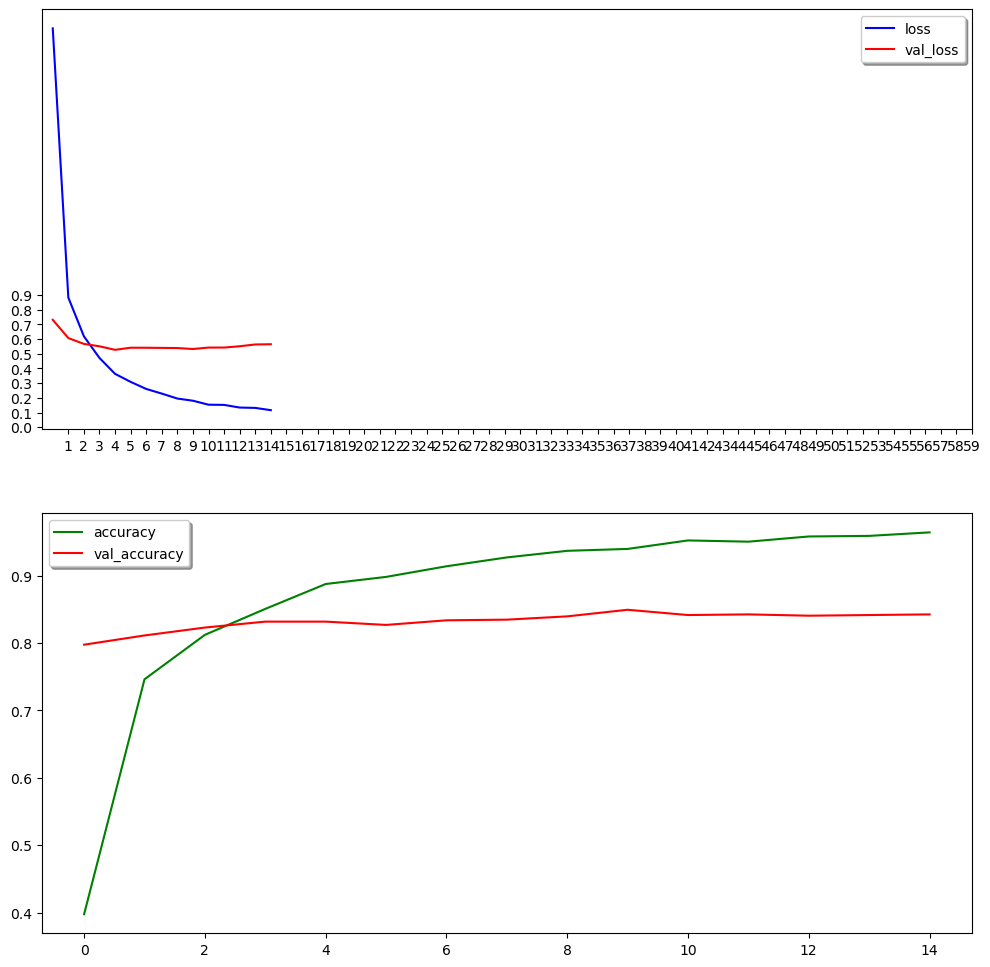

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
# ax2.set_xticks(np.arange(1, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 0.1))
plt.show()

In [25]:
from keras.models import load_model
dnn.save('/dogbreedidfromcomp/dogbreed.h5')

# saved_model = load_model('/kaggle/working/dogbreed.h5')

C:\Users\chhaa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
test_data = []
for pic in os.listdir(test_dir):
    test_data.append(test_dir+pic)

In [27]:
test_data

['./dogbreedidfromcomp/test/000621fb3cbb32d8935728e48679680e.jpg',
 './dogbreedidfromcomp/test/00102ee9d8eb90812350685311fe5890.jpg',
 './dogbreedidfromcomp/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 './dogbreedidfromcomp/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 './dogbreedidfromcomp/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 './dogbreedidfromcomp/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 './dogbreedidfromcomp/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 './dogbreedidfromcomp/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 './dogbreedidfromcomp/test/002f80396f1e3db687c5932d7978b196.jpg',
 './dogbreedidfromcomp/test/0036c6bcec6031be9e62a257b1c3c442.jpg',
 './dogbreedidfromcomp/test/0041940322116ae58c38130f5a6f71f9.jpg',
 './dogbreedidfromcomp/test/0042d6bf3e5f3700865886db32689436.jpg',
 './dogbreedidfromcomp/test/004476c96f575879af4af471af65cae8.jpg',
 './dogbreedidfromcomp/test/00485d47de966a9437ad3b33ac193b6f.jpg',
 './dogbreedidfromcomp/test/00496f65de6cc319145ce97bd6e90360.j

In [28]:
test_dataframe = pd.DataFrame({'file_name':test_data})

In [29]:
test_dataframe

,file_name
0,./dogbreedidfromcomp/test/000621fb3cbb32d89357...
1,./dogbreedidfromcomp/test/00102ee9d8eb90812350...
2,./dogbreedidfromcomp/test/0012a730dfa437f5f361...
3,./dogbreedidfromcomp/test/001510bc8570bbeee98c...
4,./dogbreedidfromcomp/test/001a5f3114548acdefa3...
...,...
10352,./dogbreedidfromcomp/test/ffeda8623d4eee33c6d1...
10353,./dogbreedidfromcomp/test/fff1ec9e6e4132759849...
10354,./dogbreedidfromcomp/test/fff74b59b758bbbf13a5...
10355,./dogbreedidfromcomp/test/fff7d50d848e8014ac1e...


In [30]:
test_features = feature_extractor(test_dataframe)

Found 10357 validated image filenames.


  0%|                                                                                          | 0/518 [00:00<?, ?it/s]

1/1 [==============================] - 1s 817ms/step


  0%|▏                                                                                 | 1/518 [00:00<08:07,  1.06it/s]

1/1 [==============================] - 1s 770ms/step


  0%|▎                                                                                 | 2/518 [00:01<07:52,  1.09it/s]

1/1 [==============================] - 1s 854ms/step


  1%|▍                                                                                 | 3/518 [00:02<08:20,  1.03it/s]

1/1 [==============================] - 1s 769ms/step


  1%|▋                                                                                 | 4/518 [00:03<08:09,  1.05it/s]

1/1 [==============================] - 1s 867ms/step


  1%|▊                                                                                 | 5/518 [00:04<08:25,  1.02it/s]

1/1 [==============================] - 1s 722ms/step


  1%|▉                                                                                 | 6/518 [00:05<08:08,  1.05it/s]

1/1 [==============================] - 1s 801ms/step


  1%|█                                                                                 | 7/518 [00:06<08:08,  1.05it/s]

1/1 [==============================] - 1s 817ms/step


  2%|█▎                                                                                | 8/518 [00:07<08:07,  1.05it/s]

1/1 [==============================] - 1s 864ms/step


  2%|█▍                                                                                | 9/518 [00:08<08:19,  1.02it/s]

1/1 [==============================] - 1s 853ms/step


  2%|█▌                                                                               | 10/518 [00:09<08:21,  1.01it/s]

1/1 [==============================] - 1s 880ms/step


  2%|█▋                                                                               | 11/518 [00:10<08:30,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


  2%|█▉                                                                               | 12/518 [00:11<08:34,  1.02s/it]

1/1 [==============================] - 1s 802ms/step


  3%|██                                                                               | 13/518 [00:12<08:29,  1.01s/it]

1/1 [==============================] - 1s 865ms/step


  3%|██▏                                                                              | 14/518 [00:13<08:25,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


  3%|██▎                                                                              | 15/518 [00:14<08:32,  1.02s/it]

1/1 [==============================] - 1s 848ms/step


  3%|██▌                                                                              | 16/518 [00:15<08:29,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


  3%|██▋                                                                              | 17/518 [00:16<08:26,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


  3%|██▊                                                                              | 18/518 [00:17<08:27,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


  4%|██▉                                                                              | 19/518 [00:18<08:25,  1.01s/it]

1/1 [==============================] - 1s 727ms/step


  4%|███▏                                                                             | 20/518 [00:19<08:04,  1.03it/s]

1/1 [==============================] - 1s 848ms/step


  4%|███▎                                                                             | 21/518 [00:20<08:08,  1.02it/s]

1/1 [==============================] - 1s 864ms/step


  4%|███▍                                                                             | 22/518 [00:21<08:13,  1.01it/s]

1/1 [==============================] - 1s 746ms/step


  4%|███▌                                                                             | 23/518 [00:22<07:58,  1.03it/s]

1/1 [==============================] - 1s 894ms/step


  5%|███▊                                                                             | 24/518 [00:23<08:08,  1.01it/s]

1/1 [==============================] - 1s 800ms/step


  5%|███▉                                                                             | 25/518 [00:24<07:58,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


  5%|████                                                                             | 26/518 [00:25<07:55,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


  5%|████▏                                                                            | 27/518 [00:26<07:51,  1.04it/s]

1/1 [==============================] - 1s 866ms/step


  5%|████▍                                                                            | 28/518 [00:27<08:03,  1.01it/s]

1/1 [==============================] - 1s 878ms/step


  6%|████▌                                                                            | 29/518 [00:28<08:09,  1.00s/it]

1/1 [==============================] - 1s 878ms/step


  6%|████▋                                                                            | 30/518 [00:29<08:11,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


  6%|████▊                                                                            | 31/518 [00:30<08:12,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


  6%|█████                                                                            | 32/518 [00:31<08:15,  1.02s/it]

1/1 [==============================] - 1s 816ms/step


  6%|█████▏                                                                           | 33/518 [00:32<08:09,  1.01s/it]

1/1 [==============================] - 1s 913ms/step


  7%|█████▎                                                                           | 34/518 [00:33<08:13,  1.02s/it]

1/1 [==============================] - 1s 819ms/step


  7%|█████▍                                                                           | 35/518 [00:34<08:01,  1.00it/s]

1/1 [==============================] - 1s 770ms/step


  7%|█████▋                                                                           | 36/518 [00:35<07:52,  1.02it/s]

1/1 [==============================] - 1s 848ms/step


  7%|█████▊                                                                           | 37/518 [00:36<07:59,  1.00it/s]

1/1 [==============================] - 1s 867ms/step


  7%|█████▉                                                                           | 38/518 [00:37<08:06,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


  8%|██████                                                                           | 39/518 [00:38<08:08,  1.02s/it]

1/1 [==============================] - 1s 885ms/step


  8%|██████▎                                                                          | 40/518 [00:39<08:08,  1.02s/it]

1/1 [==============================] - 1s 832ms/step


  8%|██████▍                                                                          | 41/518 [00:40<08:05,  1.02s/it]

1/1 [==============================] - 1s 832ms/step


  8%|██████▌                                                                          | 42/518 [00:41<08:02,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


  8%|██████▋                                                                          | 43/518 [00:42<08:00,  1.01s/it]

1/1 [==============================] - 1s 801ms/step


  8%|██████▉                                                                          | 44/518 [00:43<07:51,  1.00it/s]

1/1 [==============================] - 1s 852ms/step


  9%|███████                                                                          | 45/518 [00:44<07:50,  1.01it/s]

1/1 [==============================] - 1s 769ms/step


  9%|███████▏                                                                         | 46/518 [00:45<07:42,  1.02it/s]

1/1 [==============================] - 1s 832ms/step


  9%|███████▎                                                                         | 47/518 [00:46<07:42,  1.02it/s]

1/1 [==============================] - 1s 786ms/step


  9%|███████▌                                                                         | 48/518 [00:47<07:36,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


  9%|███████▋                                                                         | 49/518 [00:48<07:35,  1.03it/s]

1/1 [==============================] - 1s 856ms/step


 10%|███████▊                                                                         | 50/518 [00:49<07:38,  1.02it/s]

1/1 [==============================] - 1s 911ms/step


 10%|███████▉                                                                         | 51/518 [00:50<07:49,  1.01s/it]

1/1 [==============================] - 1s 785ms/step


 10%|████████▏                                                                        | 52/518 [00:51<07:39,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 10%|████████▎                                                                        | 53/518 [00:52<07:41,  1.01it/s]

1/1 [==============================] - 1s 800ms/step


 10%|████████▍                                                                        | 54/518 [00:53<07:39,  1.01it/s]

1/1 [==============================] - 1s 885ms/step


 11%|████████▌                                                                        | 55/518 [00:54<07:44,  1.00s/it]

1/1 [==============================] - 1s 848ms/step


 11%|████████▊                                                                        | 56/518 [00:55<07:43,  1.00s/it]

1/1 [==============================] - 1s 817ms/step


 11%|████████▉                                                                        | 57/518 [00:56<07:36,  1.01it/s]

1/1 [==============================] - 1s 863ms/step


 11%|█████████                                                                        | 58/518 [00:57<07:41,  1.00s/it]

1/1 [==============================] - 1s 895ms/step


 11%|█████████▏                                                                       | 59/518 [00:58<07:47,  1.02s/it]

1/1 [==============================] - 1s 820ms/step


 12%|█████████▍                                                                       | 60/518 [00:59<07:42,  1.01s/it]

1/1 [==============================] - 1s 784ms/step


 12%|█████████▌                                                                       | 61/518 [01:00<07:32,  1.01it/s]

1/1 [==============================] - 1s 849ms/step


 12%|█████████▋                                                                       | 62/518 [01:01<07:31,  1.01it/s]

1/1 [==============================] - 1s 802ms/step


 12%|█████████▊                                                                       | 63/518 [01:02<07:26,  1.02it/s]

1/1 [==============================] - 1s 800ms/step


 12%|██████████                                                                       | 64/518 [01:03<07:20,  1.03it/s]

1/1 [==============================] - 1s 850ms/step


 13%|██████████▏                                                                      | 65/518 [01:04<07:30,  1.00it/s]

1/1 [==============================] - 1s 863ms/step


 13%|██████████▎                                                                      | 66/518 [01:05<07:30,  1.00it/s]

1/1 [==============================] - 1s 800ms/step


 13%|██████████▍                                                                      | 67/518 [01:06<07:26,  1.01it/s]

1/1 [==============================] - 1s 801ms/step


 13%|██████████▋                                                                      | 68/518 [01:07<07:21,  1.02it/s]

1/1 [==============================] - 1s 849ms/step


 13%|██████████▊                                                                      | 69/518 [01:08<07:23,  1.01it/s]

1/1 [==============================] - 1s 748ms/step


 14%|██████████▉                                                                      | 70/518 [01:09<07:14,  1.03it/s]

1/1 [==============================] - 1s 862ms/step


 14%|███████████                                                                      | 71/518 [01:10<07:20,  1.01it/s]

1/1 [==============================] - 1s 801ms/step


 14%|███████████▎                                                                     | 72/518 [01:11<07:16,  1.02it/s]

1/1 [==============================] - 1s 817ms/step


 14%|███████████▍                                                                     | 73/518 [01:12<07:13,  1.03it/s]

1/1 [==============================] - 1s 769ms/step


 14%|███████████▌                                                                     | 74/518 [01:13<07:03,  1.05it/s]

1/1 [==============================] - 1s 816ms/step


 14%|███████████▋                                                                     | 75/518 [01:14<07:07,  1.04it/s]

1/1 [==============================] - 1s 794ms/step


 15%|███████████▉                                                                     | 76/518 [01:15<07:04,  1.04it/s]

1/1 [==============================] - 1s 844ms/step


 15%|████████████                                                                     | 77/518 [01:16<07:11,  1.02it/s]

1/1 [==============================] - 1s 832ms/step


 15%|████████████▏                                                                    | 78/518 [01:17<07:11,  1.02it/s]

1/1 [==============================] - 1s 785ms/step


 15%|████████████▎                                                                    | 79/518 [01:18<07:07,  1.03it/s]

1/1 [==============================] - 1s 833ms/step


 15%|████████████▌                                                                    | 80/518 [01:19<07:11,  1.02it/s]

1/1 [==============================] - 1s 850ms/step


 16%|████████████▋                                                                    | 81/518 [01:20<07:15,  1.00it/s]

1/1 [==============================] - 1s 817ms/step


 16%|████████████▊                                                                    | 82/518 [01:21<07:15,  1.00it/s]

1/1 [==============================] - 1s 817ms/step


 16%|████████████▉                                                                    | 83/518 [01:22<07:13,  1.00it/s]

1/1 [==============================] - 1s 816ms/step


 16%|█████████████▏                                                                   | 84/518 [01:23<07:09,  1.01it/s]

1/1 [==============================] - 1s 895ms/step


 16%|█████████████▎                                                                   | 85/518 [01:24<07:16,  1.01s/it]

1/1 [==============================] - 1s 871ms/step


 17%|█████████████▍                                                                   | 86/518 [01:25<07:14,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 17%|█████████████▌                                                                   | 87/518 [01:26<07:13,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 17%|█████████████▊                                                                   | 88/518 [01:27<07:18,  1.02s/it]

1/1 [==============================] - 1s 847ms/step


 17%|█████████████▉                                                                   | 89/518 [01:28<07:15,  1.01s/it]

1/1 [==============================] - 1s 803ms/step


 17%|██████████████                                                                   | 90/518 [01:29<07:05,  1.01it/s]

1/1 [==============================] - 1s 849ms/step


 18%|██████████████▏                                                                  | 91/518 [01:30<07:08,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 18%|██████████████▍                                                                  | 92/518 [01:31<07:09,  1.01s/it]

1/1 [==============================] - 1s 865ms/step


 18%|██████████████▌                                                                  | 93/518 [01:32<07:14,  1.02s/it]

1/1 [==============================] - 1s 835ms/step


 18%|██████████████▋                                                                  | 94/518 [01:33<07:07,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


 18%|██████████████▊                                                                  | 95/518 [01:34<07:09,  1.02s/it]

1/1 [==============================] - 1s 838ms/step


 19%|███████████████                                                                  | 96/518 [01:35<07:08,  1.01s/it]

1/1 [==============================] - 1s 849ms/step


 19%|███████████████▏                                                                 | 97/518 [01:36<07:04,  1.01s/it]

1/1 [==============================] - 1s 848ms/step


 19%|███████████████▎                                                                 | 98/518 [01:37<07:00,  1.00s/it]

1/1 [==============================] - 1s 865ms/step


 19%|███████████████▍                                                                 | 99/518 [01:38<07:02,  1.01s/it]

1/1 [==============================] - 1s 861ms/step


 19%|███████████████▍                                                                | 100/518 [01:39<07:05,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 19%|███████████████▌                                                                | 101/518 [01:40<06:56,  1.00it/s]

1/1 [==============================] - 1s 880ms/step


 20%|███████████████▊                                                                | 102/518 [01:41<07:00,  1.01s/it]

1/1 [==============================] - 1s 816ms/step


 20%|███████████████▉                                                                | 103/518 [01:42<06:54,  1.00it/s]

1/1 [==============================] - 1s 824ms/step


 20%|████████████████                                                                | 104/518 [01:43<06:54,  1.00s/it]

1/1 [==============================] - 1s 864ms/step


 20%|████████████████▏                                                               | 105/518 [01:44<06:54,  1.00s/it]

1/1 [==============================] - 1s 849ms/step


 20%|████████████████▎                                                               | 106/518 [01:45<06:54,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


 21%|████████████████▌                                                               | 107/518 [01:46<06:57,  1.02s/it]

1/1 [==============================] - 1s 802ms/step


 21%|████████████████▋                                                               | 108/518 [01:47<06:47,  1.01it/s]

1/1 [==============================] - 1s 770ms/step


 21%|████████████████▊                                                               | 109/518 [01:48<06:36,  1.03it/s]

1/1 [==============================] - 1s 802ms/step


 21%|████████████████▉                                                               | 110/518 [01:49<06:34,  1.04it/s]

1/1 [==============================] - 1s 867ms/step


 21%|█████████████████▏                                                              | 111/518 [01:50<06:40,  1.02it/s]

1/1 [==============================] - 1s 833ms/step


 22%|█████████████████▎                                                              | 112/518 [01:51<06:40,  1.01it/s]

1/1 [==============================] - 1s 817ms/step


 22%|█████████████████▍                                                              | 113/518 [01:52<06:37,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 22%|█████████████████▌                                                              | 114/518 [01:53<06:35,  1.02it/s]

1/1 [==============================] - 1s 812ms/step


 22%|█████████████████▊                                                              | 115/518 [01:54<06:36,  1.02it/s]

1/1 [==============================] - 1s 711ms/step


 22%|█████████████████▉                                                              | 116/518 [01:55<06:20,  1.06it/s]

1/1 [==============================] - 1s 800ms/step


 23%|██████████████████                                                              | 117/518 [01:56<06:26,  1.04it/s]

1/1 [==============================] - 1s 706ms/step


 23%|██████████████████▏                                                             | 118/518 [01:56<06:14,  1.07it/s]

1/1 [==============================] - 1s 791ms/step


 23%|██████████████████▍                                                             | 119/518 [01:57<06:17,  1.06it/s]

1/1 [==============================] - 1s 716ms/step


 23%|██████████████████▌                                                             | 120/518 [01:58<06:06,  1.09it/s]

1/1 [==============================] - 1s 810ms/step


 23%|██████████████████▋                                                             | 121/518 [01:59<06:12,  1.07it/s]

1/1 [==============================] - 1s 806ms/step


 24%|██████████████████▊                                                             | 122/518 [02:00<06:14,  1.06it/s]

1/1 [==============================] - 1s 904ms/step


 24%|██████████████████▉                                                             | 123/518 [02:01<06:26,  1.02it/s]

1/1 [==============================] - 1s 838ms/step


 24%|███████████████████▏                                                            | 124/518 [02:02<06:29,  1.01it/s]

1/1 [==============================] - 1s 758ms/step


 24%|███████████████████▎                                                            | 125/518 [02:03<06:19,  1.04it/s]

1/1 [==============================] - 1s 803ms/step


 24%|███████████████████▍                                                            | 126/518 [02:04<06:19,  1.03it/s]

1/1 [==============================] - 1s 847ms/step


 25%|███████████████████▌                                                            | 127/518 [02:05<06:21,  1.03it/s]

1/1 [==============================] - 1s 864ms/step


 25%|███████████████████▊                                                            | 128/518 [02:06<06:26,  1.01it/s]

1/1 [==============================] - 1s 738ms/step


 25%|███████████████████▉                                                            | 129/518 [02:07<06:11,  1.05it/s]

1/1 [==============================] - 1s 817ms/step


 25%|████████████████████                                                            | 130/518 [02:08<06:12,  1.04it/s]

1/1 [==============================] - 1s 864ms/step


 25%|████████████████████▏                                                           | 131/518 [02:09<06:17,  1.03it/s]

1/1 [==============================] - 1s 873ms/step


 25%|████████████████████▍                                                           | 132/518 [02:10<06:19,  1.02it/s]

1/1 [==============================] - 1s 817ms/step


 26%|████████████████████▌                                                           | 133/518 [02:11<06:17,  1.02it/s]

1/1 [==============================] - 1s 816ms/step


 26%|████████████████████▋                                                           | 134/518 [02:12<06:17,  1.02it/s]

1/1 [==============================] - 1s 911ms/step


 26%|████████████████████▊                                                           | 135/518 [02:13<06:24,  1.00s/it]

1/1 [==============================] - 1s 902ms/step


 26%|█████████████████████                                                           | 136/518 [02:14<06:26,  1.01s/it]

1/1 [==============================] - 1s 832ms/step


 26%|█████████████████████▏                                                          | 137/518 [02:15<06:22,  1.00s/it]

1/1 [==============================] - 1s 816ms/step


 27%|█████████████████████▎                                                          | 138/518 [02:16<06:18,  1.00it/s]

1/1 [==============================] - 1s 834ms/step


 27%|█████████████████████▍                                                          | 139/518 [02:17<06:18,  1.00it/s]

1/1 [==============================] - 1s 722ms/step


 27%|█████████████████████▌                                                          | 140/518 [02:18<06:01,  1.05it/s]

1/1 [==============================] - 1s 895ms/step


 27%|█████████████████████▊                                                          | 141/518 [02:19<06:09,  1.02it/s]

1/1 [==============================] - 1s 726ms/step


 27%|█████████████████████▉                                                          | 142/518 [02:20<05:55,  1.06it/s]

1/1 [==============================] - 1s 785ms/step


 28%|██████████████████████                                                          | 143/518 [02:21<05:55,  1.05it/s]

1/1 [==============================] - 1s 810ms/step


 28%|██████████████████████▏                                                         | 144/518 [02:22<05:55,  1.05it/s]

1/1 [==============================] - 1s 811ms/step


 28%|██████████████████████▍                                                         | 145/518 [02:23<06:02,  1.03it/s]

1/1 [==============================] - 1s 820ms/step


 28%|██████████████████████▌                                                         | 146/518 [02:24<06:03,  1.02it/s]

1/1 [==============================] - 1s 832ms/step


 28%|██████████████████████▋                                                         | 147/518 [02:25<06:02,  1.02it/s]

1/1 [==============================] - 1s 768ms/step


 29%|██████████████████████▊                                                         | 148/518 [02:26<05:53,  1.05it/s]

1/1 [==============================] - 1s 785ms/step


 29%|███████████████████████                                                         | 149/518 [02:27<05:47,  1.06it/s]

1/1 [==============================] - 1s 775ms/step


 29%|███████████████████████▏                                                        | 150/518 [02:27<05:43,  1.07it/s]

1/1 [==============================] - 1s 753ms/step


 29%|███████████████████████▎                                                        | 151/518 [02:28<05:37,  1.09it/s]

1/1 [==============================] - 1s 801ms/step


 29%|███████████████████████▍                                                        | 152/518 [02:29<05:39,  1.08it/s]

1/1 [==============================] - 1s 754ms/step


 30%|███████████████████████▋                                                        | 153/518 [02:30<05:36,  1.08it/s]

1/1 [==============================] - 1s 856ms/step


 30%|███████████████████████▊                                                        | 154/518 [02:31<05:43,  1.06it/s]

1/1 [==============================] - 1s 769ms/step


 30%|███████████████████████▉                                                        | 155/518 [02:32<05:42,  1.06it/s]

1/1 [==============================] - 1s 944ms/step


 30%|████████████████████████                                                        | 156/518 [02:33<05:58,  1.01it/s]

1/1 [==============================] - 1s 813ms/step


 30%|████████████████████████▏                                                       | 157/518 [02:34<05:57,  1.01it/s]

1/1 [==============================] - 1s 832ms/step


 31%|████████████████████████▍                                                       | 158/518 [02:35<06:01,  1.00s/it]

1/1 [==============================] - 1s 817ms/step


 31%|████████████████████████▌                                                       | 159/518 [02:36<05:59,  1.00s/it]

1/1 [==============================] - 1s 809ms/step


 31%|████████████████████████▋                                                       | 160/518 [02:37<05:54,  1.01it/s]

1/1 [==============================] - 1s 786ms/step


 31%|████████████████████████▊                                                       | 161/518 [02:38<05:51,  1.02it/s]

1/1 [==============================] - 1s 809ms/step


 31%|█████████████████████████                                                       | 162/518 [02:39<05:53,  1.01it/s]

1/1 [==============================] - 1s 802ms/step


 31%|█████████████████████████▏                                                      | 163/518 [02:40<05:53,  1.01it/s]

1/1 [==============================] - 1s 833ms/step


 32%|█████████████████████████▎                                                      | 164/518 [02:41<05:49,  1.01it/s]

1/1 [==============================] - 1s 816ms/step


 32%|█████████████████████████▍                                                      | 165/518 [02:42<05:49,  1.01it/s]

1/1 [==============================] - 1s 785ms/step


 32%|█████████████████████████▋                                                      | 166/518 [02:43<05:41,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


 32%|█████████████████████████▊                                                      | 167/518 [02:44<05:39,  1.03it/s]

1/1 [==============================] - 1s 879ms/step


 32%|█████████████████████████▉                                                      | 168/518 [02:45<05:44,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 33%|██████████████████████████                                                      | 169/518 [02:46<05:46,  1.01it/s]

1/1 [==============================] - 1s 816ms/step


 33%|██████████████████████████▎                                                     | 170/518 [02:47<05:45,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 33%|██████████████████████████▍                                                     | 171/518 [02:48<05:45,  1.00it/s]

1/1 [==============================] - 1s 895ms/step


 33%|██████████████████████████▌                                                     | 172/518 [02:49<05:48,  1.01s/it]

1/1 [==============================] - 1s 880ms/step


 33%|██████████████████████████▋                                                     | 173/518 [02:50<05:50,  1.02s/it]

1/1 [==============================] - 1s 884ms/step


 34%|██████████████████████████▊                                                     | 174/518 [02:51<05:52,  1.02s/it]

1/1 [==============================] - 1s 754ms/step


 34%|███████████████████████████                                                     | 175/518 [02:52<05:40,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 34%|███████████████████████████▏                                                    | 176/518 [02:53<05:42,  1.00s/it]

1/1 [==============================] - 1s 833ms/step


 34%|███████████████████████████▎                                                    | 177/518 [02:54<05:41,  1.00s/it]

1/1 [==============================] - 1s 878ms/step


 34%|███████████████████████████▍                                                    | 178/518 [02:55<05:43,  1.01s/it]

1/1 [==============================] - 1s 862ms/step


 35%|███████████████████████████▋                                                    | 179/518 [02:56<05:43,  1.01s/it]

1/1 [==============================] - 1s 833ms/step


 35%|███████████████████████████▊                                                    | 180/518 [02:57<05:38,  1.00s/it]

1/1 [==============================] - 1s 842ms/step


 35%|███████████████████████████▉                                                    | 181/518 [02:58<05:42,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 35%|████████████████████████████                                                    | 182/518 [02:59<05:35,  1.00it/s]

1/1 [==============================] - 1s 769ms/step


 35%|████████████████████████████▎                                                   | 183/518 [03:00<05:27,  1.02it/s]

1/1 [==============================] - 1s 828ms/step


 36%|████████████████████████████▍                                                   | 184/518 [03:01<05:27,  1.02it/s]

1/1 [==============================] - 1s 738ms/step


 36%|████████████████████████████▌                                                   | 185/518 [03:02<05:15,  1.06it/s]

1/1 [==============================] - 1s 754ms/step


 36%|████████████████████████████▋                                                   | 186/518 [03:03<05:10,  1.07it/s]

1/1 [==============================] - 1s 831ms/step


 36%|████████████████████████████▉                                                   | 187/518 [03:04<05:16,  1.05it/s]

1/1 [==============================] - 1s 819ms/step


 36%|█████████████████████████████                                                   | 188/518 [03:05<05:18,  1.04it/s]

1/1 [==============================] - 1s 816ms/step


 36%|█████████████████████████████▏                                                  | 189/518 [03:06<05:21,  1.02it/s]

1/1 [==============================] - 1s 754ms/step


 37%|█████████████████████████████▎                                                  | 190/518 [03:07<05:12,  1.05it/s]

1/1 [==============================] - 1s 723ms/step


 37%|█████████████████████████████▍                                                  | 191/518 [03:08<05:04,  1.07it/s]

1/1 [==============================] - 1s 864ms/step


 37%|█████████████████████████████▋                                                  | 192/518 [03:09<05:15,  1.03it/s]

1/1 [==============================] - 1s 873ms/step


 37%|█████████████████████████████▊                                                  | 193/518 [03:10<05:18,  1.02it/s]

1/1 [==============================] - 1s 832ms/step


 37%|█████████████████████████████▉                                                  | 194/518 [03:11<05:21,  1.01it/s]

1/1 [==============================] - 1s 778ms/step


 38%|██████████████████████████████                                                  | 195/518 [03:12<05:14,  1.03it/s]

1/1 [==============================] - 1s 832ms/step


 38%|██████████████████████████████▎                                                 | 196/518 [03:13<05:13,  1.03it/s]

1/1 [==============================] - 1s 879ms/step


 38%|██████████████████████████████▍                                                 | 197/518 [03:14<05:18,  1.01it/s]

1/1 [==============================] - 1s 886ms/step


 38%|██████████████████████████████▌                                                 | 198/518 [03:15<05:22,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 38%|██████████████████████████████▋                                                 | 199/518 [03:16<05:24,  1.02s/it]

1/1 [==============================] - 1s 816ms/step


 39%|██████████████████████████████▉                                                 | 200/518 [03:17<05:19,  1.00s/it]

1/1 [==============================] - 1s 848ms/step


 39%|███████████████████████████████                                                 | 201/518 [03:18<05:19,  1.01s/it]

1/1 [==============================] - 1s 880ms/step


 39%|███████████████████████████████▏                                                | 202/518 [03:19<05:21,  1.02s/it]

1/1 [==============================] - 1s 725ms/step


 39%|███████████████████████████████▎                                                | 203/518 [03:20<05:09,  1.02it/s]

1/1 [==============================] - 1s 785ms/step


 39%|███████████████████████████████▌                                                | 204/518 [03:21<05:06,  1.03it/s]

1/1 [==============================] - 1s 878ms/step


 40%|███████████████████████████████▋                                                | 205/518 [03:22<05:09,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 40%|███████████████████████████████▊                                                | 206/518 [03:23<05:11,  1.00it/s]

1/1 [==============================] - 1s 863ms/step


 40%|███████████████████████████████▉                                                | 207/518 [03:24<05:12,  1.00s/it]

1/1 [==============================] - 1s 874ms/step


 40%|████████████████████████████████                                                | 208/518 [03:25<05:12,  1.01s/it]

1/1 [==============================] - 1s 864ms/step


 40%|████████████████████████████████▎                                               | 209/518 [03:26<05:13,  1.02s/it]

1/1 [==============================] - 1s 801ms/step


 41%|████████████████████████████████▍                                               | 210/518 [03:27<05:07,  1.00it/s]

1/1 [==============================] - 1s 864ms/step


 41%|████████████████████████████████▌                                               | 211/518 [03:28<05:07,  1.00s/it]

1/1 [==============================] - 1s 916ms/step


 41%|████████████████████████████████▋                                               | 212/518 [03:29<05:12,  1.02s/it]

1/1 [==============================] - 1s 816ms/step


 41%|████████████████████████████████▉                                               | 213/518 [03:30<05:08,  1.01s/it]

1/1 [==============================] - 1s 817ms/step


 41%|█████████████████████████████████                                               | 214/518 [03:31<05:03,  1.00it/s]

1/1 [==============================] - 1s 784ms/step


 42%|█████████████████████████████████▏                                              | 215/518 [03:32<04:54,  1.03it/s]

1/1 [==============================] - 1s 815ms/step


 42%|█████████████████████████████████▎                                              | 216/518 [03:33<04:53,  1.03it/s]

1/1 [==============================] - 1s 746ms/step


 42%|█████████████████████████████████▌                                              | 217/518 [03:33<04:43,  1.06it/s]

1/1 [==============================] - 1s 863ms/step


 42%|█████████████████████████████████▋                                              | 218/518 [03:35<04:51,  1.03it/s]

1/1 [==============================] - 1s 864ms/step


 42%|█████████████████████████████████▊                                              | 219/518 [03:36<04:55,  1.01it/s]

1/1 [==============================] - 1s 769ms/step


 42%|█████████████████████████████████▉                                              | 220/518 [03:36<04:47,  1.04it/s]

1/1 [==============================] - 1s 884ms/step


 43%|██████████████████████████████████▏                                             | 221/518 [03:38<04:56,  1.00it/s]

1/1 [==============================] - 1s 879ms/step


 43%|██████████████████████████████████▎                                             | 222/518 [03:39<04:56,  1.00s/it]

1/1 [==============================] - 1s 808ms/step


 43%|██████████████████████████████████▍                                             | 223/518 [03:40<04:53,  1.00it/s]

1/1 [==============================] - 1s 863ms/step


 43%|██████████████████████████████████▌                                             | 224/518 [03:41<05:00,  1.02s/it]

1/1 [==============================] - 1s 829ms/step


 43%|██████████████████████████████████▋                                             | 225/518 [03:42<04:58,  1.02s/it]

1/1 [==============================] - 1s 722ms/step


 44%|██████████████████████████████████▉                                             | 226/518 [03:42<04:43,  1.03it/s]

1/1 [==============================] - 1s 816ms/step


 44%|███████████████████████████████████                                             | 227/518 [03:43<04:42,  1.03it/s]

1/1 [==============================] - 1s 857ms/step


 44%|███████████████████████████████████▏                                            | 228/518 [03:44<04:45,  1.02it/s]

1/1 [==============================] - 1s 847ms/step


 44%|███████████████████████████████████▎                                            | 229/518 [03:45<04:47,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 44%|███████████████████████████████████▌                                            | 230/518 [03:46<04:46,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 45%|███████████████████████████████████▋                                            | 231/518 [03:47<04:48,  1.01s/it]

1/1 [==============================] - 1s 848ms/step


 45%|███████████████████████████████████▊                                            | 232/518 [03:48<04:47,  1.01s/it]

1/1 [==============================] - 1s 848ms/step


 45%|███████████████████████████████████▉                                            | 233/518 [03:50<04:47,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


 45%|████████████████████████████████████▏                                           | 234/518 [03:51<04:55,  1.04s/it]

1/1 [==============================] - 1s 754ms/step


 45%|████████████████████████████████████▎                                           | 235/518 [03:52<04:43,  1.00s/it]

1/1 [==============================] - 1s 748ms/step


 46%|████████████████████████████████████▍                                           | 236/518 [03:52<04:34,  1.03it/s]

1/1 [==============================] - 1s 739ms/step


 46%|████████████████████████████████████▌                                           | 237/518 [03:53<04:32,  1.03it/s]

1/1 [==============================] - 1s 902ms/step


 46%|████████████████████████████████████▊                                           | 238/518 [03:54<04:37,  1.01it/s]

1/1 [==============================] - 1s 801ms/step


 46%|████████████████████████████████████▉                                           | 239/518 [03:55<04:33,  1.02it/s]

1/1 [==============================] - 1s 847ms/step


 46%|█████████████████████████████████████                                           | 240/518 [03:56<04:33,  1.02it/s]

1/1 [==============================] - 1s 832ms/step


 47%|█████████████████████████████████████▏                                          | 241/518 [03:57<04:34,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 47%|█████████████████████████████████████▎                                          | 242/518 [03:58<04:39,  1.01s/it]

1/1 [==============================] - 1s 762ms/step


 47%|█████████████████████████████████████▌                                          | 243/518 [03:59<04:32,  1.01it/s]

1/1 [==============================] - 1s 800ms/step


 47%|█████████████████████████████████████▋                                          | 244/518 [04:00<04:28,  1.02it/s]

1/1 [==============================] - 1s 723ms/step


 47%|█████████████████████████████████████▊                                          | 245/518 [04:01<04:19,  1.05it/s]

1/1 [==============================] - 1s 816ms/step


 47%|█████████████████████████████████████▉                                          | 246/518 [04:02<04:21,  1.04it/s]

1/1 [==============================] - 1s 864ms/step


 48%|██████████████████████████████████████▏                                         | 247/518 [04:03<04:25,  1.02it/s]

1/1 [==============================] - 1s 825ms/step


 48%|██████████████████████████████████████▎                                         | 248/518 [04:04<04:24,  1.02it/s]

1/1 [==============================] - 1s 817ms/step


 48%|██████████████████████████████████████▍                                         | 249/518 [04:05<04:24,  1.02it/s]

1/1 [==============================] - 1s 867ms/step


 48%|██████████████████████████████████████▌                                         | 250/518 [04:06<04:25,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 48%|██████████████████████████████████████▊                                         | 251/518 [04:07<04:23,  1.01it/s]

1/1 [==============================] - 1s 801ms/step


 49%|██████████████████████████████████████▉                                         | 252/518 [04:08<04:19,  1.03it/s]

1/1 [==============================] - 1s 770ms/step


 49%|███████████████████████████████████████                                         | 253/518 [04:09<04:14,  1.04it/s]

1/1 [==============================] - 1s 816ms/step


 49%|███████████████████████████████████████▏                                        | 254/518 [04:10<04:16,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


 49%|███████████████████████████████████████▍                                        | 255/518 [04:11<04:14,  1.03it/s]

1/1 [==============================] - 1s 832ms/step


 49%|███████████████████████████████████████▌                                        | 256/518 [04:12<04:16,  1.02it/s]

1/1 [==============================] - 1s 754ms/step


 50%|███████████████████████████████████████▋                                        | 257/518 [04:13<04:09,  1.04it/s]

1/1 [==============================] - 1s 863ms/step


 50%|███████████████████████████████████████▊                                        | 258/518 [04:14<04:15,  1.02it/s]

1/1 [==============================] - 1s 850ms/step


 50%|████████████████████████████████████████                                        | 259/518 [04:15<04:17,  1.00it/s]

1/1 [==============================] - 1s 801ms/step


 50%|████████████████████████████████████████▏                                       | 260/518 [04:16<04:14,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 50%|████████████████████████████████████████▎                                       | 261/518 [04:17<04:14,  1.01it/s]

1/1 [==============================] - 1s 816ms/step


 51%|████████████████████████████████████████▍                                       | 262/518 [04:18<04:12,  1.01it/s]

1/1 [==============================] - 1s 894ms/step


 51%|████████████████████████████████████████▌                                       | 263/518 [04:19<04:16,  1.00s/it]

1/1 [==============================] - 1s 793ms/step


 51%|████████████████████████████████████████▊                                       | 264/518 [04:20<04:11,  1.01it/s]

1/1 [==============================] - 1s 847ms/step


 51%|████████████████████████████████████████▉                                       | 265/518 [04:21<04:10,  1.01it/s]

1/1 [==============================] - 1s 879ms/step


 51%|█████████████████████████████████████████                                       | 266/518 [04:22<04:13,  1.01s/it]

1/1 [==============================] - 1s 879ms/step


 52%|█████████████████████████████████████████▏                                      | 267/518 [04:23<04:13,  1.01s/it]

1/1 [==============================] - 1s 811ms/step


 52%|█████████████████████████████████████████▍                                      | 268/518 [04:24<04:09,  1.00it/s]

1/1 [==============================] - 1s 812ms/step


 52%|█████████████████████████████████████████▌                                      | 269/518 [04:25<04:05,  1.01it/s]

1/1 [==============================] - 1s 817ms/step


 52%|█████████████████████████████████████████▋                                      | 270/518 [04:26<04:03,  1.02it/s]

1/1 [==============================] - 1s 753ms/step


 52%|█████████████████████████████████████████▊                                      | 271/518 [04:27<03:57,  1.04it/s]

1/1 [==============================] - 1s 769ms/step


 53%|██████████████████████████████████████████                                      | 272/518 [04:28<03:52,  1.06it/s]

1/1 [==============================] - 1s 878ms/step


 53%|██████████████████████████████████████████▏                                     | 273/518 [04:29<03:57,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


 53%|██████████████████████████████████████████▎                                     | 274/518 [04:30<03:54,  1.04it/s]

1/1 [==============================] - 1s 879ms/step


 53%|██████████████████████████████████████████▍                                     | 275/518 [04:31<03:58,  1.02it/s]

1/1 [==============================] - 1s 722ms/step


 53%|██████████████████████████████████████████▋                                     | 276/518 [04:32<03:50,  1.05it/s]

1/1 [==============================] - 1s 879ms/step


 53%|██████████████████████████████████████████▊                                     | 277/518 [04:33<03:56,  1.02it/s]

1/1 [==============================] - 1s 883ms/step


 54%|██████████████████████████████████████████▉                                     | 278/518 [04:34<03:58,  1.01it/s]

1/1 [==============================] - 1s 748ms/step


 54%|███████████████████████████████████████████                                     | 279/518 [04:35<03:51,  1.03it/s]

1/1 [==============================] - 1s 863ms/step


 54%|███████████████████████████████████████████▏                                    | 280/518 [04:36<03:54,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 54%|███████████████████████████████████████████▍                                    | 281/518 [04:37<03:55,  1.00it/s]

1/1 [==============================] - 1s 864ms/step


 54%|███████████████████████████████████████████▌                                    | 282/518 [04:38<03:56,  1.00s/it]

1/1 [==============================] - 1s 863ms/step


 55%|███████████████████████████████████████████▋                                    | 283/518 [04:39<03:58,  1.01s/it]

1/1 [==============================] - 1s 792ms/step


 55%|███████████████████████████████████████████▊                                    | 284/518 [04:40<03:51,  1.01it/s]

1/1 [==============================] - 1s 815ms/step


 55%|████████████████████████████████████████████                                    | 285/518 [04:41<03:49,  1.02it/s]

1/1 [==============================] - 1s 879ms/step


 55%|████████████████████████████████████████████▏                                   | 286/518 [04:42<03:51,  1.00it/s]

1/1 [==============================] - 1s 817ms/step


 55%|████████████████████████████████████████████▎                                   | 287/518 [04:43<03:48,  1.01it/s]

1/1 [==============================] - 1s 910ms/step


 56%|████████████████████████████████████████████▍                                   | 288/518 [04:44<03:52,  1.01s/it]

1/1 [==============================] - 1s 796ms/step


 56%|████████████████████████████████████████████▋                                   | 289/518 [04:45<03:48,  1.00it/s]

1/1 [==============================] - 1s 738ms/step


 56%|████████████████████████████████████████████▊                                   | 290/518 [04:46<03:41,  1.03it/s]

1/1 [==============================] - 1s 880ms/step


 56%|████████████████████████████████████████████▉                                   | 291/518 [04:47<03:45,  1.00it/s]

1/1 [==============================] - 1s 832ms/step


 56%|█████████████████████████████████████████████                                   | 292/518 [04:48<03:43,  1.01it/s]

1/1 [==============================] - 1s 785ms/step


 57%|█████████████████████████████████████████████▎                                  | 293/518 [04:48<03:38,  1.03it/s]

1/1 [==============================] - 1s 792ms/step


 57%|█████████████████████████████████████████████▍                                  | 294/518 [04:49<03:35,  1.04it/s]

1/1 [==============================] - 1s 817ms/step


 57%|█████████████████████████████████████████████▌                                  | 295/518 [04:50<03:35,  1.03it/s]

1/1 [==============================] - 1s 817ms/step


 57%|█████████████████████████████████████████████▋                                  | 296/518 [04:51<03:34,  1.04it/s]

1/1 [==============================] - 1s 816ms/step


 57%|█████████████████████████████████████████████▊                                  | 297/518 [04:52<03:32,  1.04it/s]

1/1 [==============================] - 1s 761ms/step


 58%|██████████████████████████████████████████████                                  | 298/518 [04:53<03:28,  1.06it/s]

1/1 [==============================] - 1s 746ms/step


 58%|██████████████████████████████████████████████▏                                 | 299/518 [04:54<03:27,  1.06it/s]

1/1 [==============================] - 1s 818ms/step


 58%|██████████████████████████████████████████████▎                                 | 300/518 [04:55<03:28,  1.05it/s]

1/1 [==============================] - 1s 769ms/step


 58%|██████████████████████████████████████████████▍                                 | 301/518 [04:56<03:23,  1.07it/s]

1/1 [==============================] - 1s 811ms/step


 58%|██████████████████████████████████████████████▋                                 | 302/518 [04:57<03:25,  1.05it/s]

1/1 [==============================] - 1s 816ms/step


 58%|██████████████████████████████████████████████▊                                 | 303/518 [04:58<03:24,  1.05it/s]

1/1 [==============================] - 1s 816ms/step


 59%|██████████████████████████████████████████████▉                                 | 304/518 [04:59<03:24,  1.05it/s]

1/1 [==============================] - 1s 848ms/step


 59%|███████████████████████████████████████████████                                 | 305/518 [05:00<03:27,  1.02it/s]

1/1 [==============================] - 1s 878ms/step


 59%|███████████████████████████████████████████████▎                                | 306/518 [05:01<03:31,  1.00it/s]

1/1 [==============================] - 1s 863ms/step


 59%|███████████████████████████████████████████████▍                                | 307/518 [05:02<03:31,  1.00s/it]

1/1 [==============================] - 1s 847ms/step


 59%|███████████████████████████████████████████████▌                                | 308/518 [05:03<03:30,  1.00s/it]

1/1 [==============================] - 1s 847ms/step


 60%|███████████████████████████████████████████████▋                                | 309/518 [05:04<03:28,  1.00it/s]

1/1 [==============================] - 1s 848ms/step


 60%|███████████████████████████████████████████████▉                                | 310/518 [05:05<03:29,  1.01s/it]

1/1 [==============================] - 1s 804ms/step


 60%|████████████████████████████████████████████████                                | 311/518 [05:06<03:24,  1.01it/s]

1/1 [==============================] - 1s 848ms/step


 60%|████████████████████████████████████████████████▏                               | 312/518 [05:07<03:26,  1.00s/it]

1/1 [==============================] - 1s 865ms/step


 60%|████████████████████████████████████████████████▎                               | 313/518 [05:08<03:27,  1.01s/it]

1/1 [==============================] - 1s 856ms/step


 61%|████████████████████████████████████████████████▍                               | 314/518 [05:09<03:26,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 61%|████████████████████████████████████████████████▋                               | 315/518 [05:10<03:22,  1.00it/s]

1/1 [==============================] - 1s 722ms/step


 61%|████████████████████████████████████████████████▊                               | 316/518 [05:11<03:15,  1.03it/s]

1/1 [==============================] - 1s 895ms/step


 61%|████████████████████████████████████████████████▉                               | 317/518 [05:12<03:18,  1.01it/s]

1/1 [==============================] - 1s 854ms/step


 61%|█████████████████████████████████████████████████                               | 318/518 [05:13<03:18,  1.01it/s]

1/1 [==============================] - 1s 850ms/step


 62%|█████████████████████████████████████████████████▎                              | 319/518 [05:14<03:17,  1.01it/s]

1/1 [==============================] - 1s 763ms/step


 62%|█████████████████████████████████████████████████▍                              | 320/518 [05:15<03:11,  1.03it/s]

1/1 [==============================] - 1s 895ms/step


 62%|█████████████████████████████████████████████████▌                              | 321/518 [05:16<03:14,  1.01it/s]

1/1 [==============================] - 1s 895ms/step


 62%|█████████████████████████████████████████████████▋                              | 322/518 [05:17<03:15,  1.00it/s]

1/1 [==============================] - 1s 886ms/step


 62%|█████████████████████████████████████████████████▉                              | 323/518 [05:18<03:16,  1.01s/it]

1/1 [==============================] - 1s 744ms/step


 63%|██████████████████████████████████████████████████                              | 324/518 [05:19<03:10,  1.02it/s]

1/1 [==============================] - 1s 810ms/step


 63%|██████████████████████████████████████████████████▏                             | 325/518 [05:20<03:09,  1.02it/s]

1/1 [==============================] - 1s 753ms/step


 63%|██████████████████████████████████████████████████▎                             | 326/518 [05:21<03:03,  1.05it/s]

1/1 [==============================] - 1s 910ms/step


 63%|██████████████████████████████████████████████████▌                             | 327/518 [05:22<03:09,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 63%|██████████████████████████████████████████████████▋                             | 328/518 [05:23<03:09,  1.00it/s]

1/1 [==============================] - 1s 832ms/step


 64%|██████████████████████████████████████████████████▊                             | 329/518 [05:24<03:07,  1.01it/s]

1/1 [==============================] - 1s 868ms/step


 64%|██████████████████████████████████████████████████▉                             | 330/518 [05:25<03:08,  1.00s/it]

1/1 [==============================] - 1s 816ms/step


 64%|███████████████████████████████████████████████████                             | 331/518 [05:26<03:07,  1.00s/it]

1/1 [==============================] - 1s 873ms/step


 64%|███████████████████████████████████████████████████▎                            | 332/518 [05:27<03:07,  1.01s/it]

1/1 [==============================] - 1s 800ms/step


 64%|███████████████████████████████████████████████████▍                            | 333/518 [05:28<03:03,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 64%|███████████████████████████████████████████████████▌                            | 334/518 [05:29<03:04,  1.01s/it]

1/1 [==============================] - 1s 863ms/step


 65%|███████████████████████████████████████████████████▋                            | 335/518 [05:30<03:03,  1.00s/it]

1/1 [==============================] - 1s 753ms/step


 65%|███████████████████████████████████████████████████▉                            | 336/518 [05:31<02:57,  1.02it/s]

1/1 [==============================] - 1s 816ms/step


 65%|████████████████████████████████████████████████████                            | 337/518 [05:32<02:56,  1.03it/s]

1/1 [==============================] - 1s 802ms/step


 65%|████████████████████████████████████████████████████▏                           | 338/518 [05:33<02:55,  1.03it/s]

1/1 [==============================] - 1s 878ms/step


 65%|████████████████████████████████████████████████████▎                           | 339/518 [05:34<02:56,  1.01it/s]

1/1 [==============================] - 1s 785ms/step


 66%|████████████████████████████████████████████████████▌                           | 340/518 [05:35<02:54,  1.02it/s]

1/1 [==============================] - 1s 800ms/step


 66%|████████████████████████████████████████████████████▋                           | 341/518 [05:36<02:51,  1.03it/s]

1/1 [==============================] - 1s 738ms/step


 66%|████████████████████████████████████████████████████▊                           | 342/518 [05:37<02:46,  1.06it/s]

1/1 [==============================] - 1s 785ms/step


 66%|████████████████████████████████████████████████████▉                           | 343/518 [05:37<02:44,  1.06it/s]

1/1 [==============================] - 1s 769ms/step


 66%|█████████████████████████████████████████████████████▏                          | 344/518 [05:38<02:42,  1.07it/s]

1/1 [==============================] - 1s 842ms/step


 67%|█████████████████████████████████████████████████████▎                          | 345/518 [05:39<02:44,  1.05it/s]

1/1 [==============================] - 1s 768ms/step


 67%|█████████████████████████████████████████████████████▍                          | 346/518 [05:40<02:42,  1.06it/s]

1/1 [==============================] - 1s 864ms/step


 67%|█████████████████████████████████████████████████████▌                          | 347/518 [05:41<02:47,  1.02it/s]

1/1 [==============================] - 1s 738ms/step


 67%|█████████████████████████████████████████████████████▋                          | 348/518 [05:42<02:42,  1.05it/s]

1/1 [==============================] - 1s 785ms/step


 67%|█████████████████████████████████████████████████████▉                          | 349/518 [05:43<02:41,  1.05it/s]

1/1 [==============================] - 1s 785ms/step


 68%|██████████████████████████████████████████████████████                          | 350/518 [05:44<02:39,  1.06it/s]

1/1 [==============================] - 1s 848ms/step


 68%|██████████████████████████████████████████████████████▏                         | 351/518 [05:45<02:41,  1.04it/s]

1/1 [==============================] - 1s 864ms/step


 68%|██████████████████████████████████████████████████████▎                         | 352/518 [05:46<02:42,  1.02it/s]

1/1 [==============================] - 1s 739ms/step


 68%|██████████████████████████████████████████████████████▌                         | 353/518 [05:47<02:38,  1.04it/s]

1/1 [==============================] - 1s 847ms/step


 68%|██████████████████████████████████████████████████████▋                         | 354/518 [05:48<02:39,  1.03it/s]

1/1 [==============================] - 1s 818ms/step


 69%|██████████████████████████████████████████████████████▊                         | 355/518 [05:49<02:39,  1.02it/s]

1/1 [==============================] - 1s 801ms/step


 69%|██████████████████████████████████████████████████████▉                         | 356/518 [05:50<02:37,  1.03it/s]

1/1 [==============================] - 1s 801ms/step


 69%|███████████████████████████████████████████████████████▏                        | 357/518 [05:51<02:35,  1.04it/s]

1/1 [==============================] - 1s 800ms/step


 69%|███████████████████████████████████████████████████████▎                        | 358/518 [05:52<02:34,  1.04it/s]

1/1 [==============================] - 1s 849ms/step


 69%|███████████████████████████████████████████████████████▍                        | 359/518 [05:53<02:35,  1.02it/s]

1/1 [==============================] - 1s 879ms/step


 69%|███████████████████████████████████████████████████████▌                        | 360/518 [05:54<02:36,  1.01it/s]

1/1 [==============================] - 1s 839ms/step


 70%|███████████████████████████████████████████████████████▊                        | 361/518 [05:55<02:37,  1.00s/it]

1/1 [==============================] - 1s 800ms/step


 70%|███████████████████████████████████████████████████████▉                        | 362/518 [05:56<02:33,  1.02it/s]

1/1 [==============================] - 1s 739ms/step


 70%|████████████████████████████████████████████████████████                        | 363/518 [05:57<02:29,  1.04it/s]

1/1 [==============================] - 1s 881ms/step


 70%|████████████████████████████████████████████████████████▏                       | 364/518 [05:58<02:30,  1.02it/s]

1/1 [==============================] - 1s 769ms/step


 70%|████████████████████████████████████████████████████████▎                       | 365/518 [05:59<02:27,  1.04it/s]

1/1 [==============================] - 1s 849ms/step


 71%|████████████████████████████████████████████████████████▌                       | 366/518 [06:00<02:27,  1.03it/s]

1/1 [==============================] - 1s 832ms/step


 71%|████████████████████████████████████████████████████████▋                       | 367/518 [06:01<02:28,  1.02it/s]

1/1 [==============================] - 1s 754ms/step


 71%|████████████████████████████████████████████████████████▊                       | 368/518 [06:02<02:24,  1.04it/s]

1/1 [==============================] - 1s 864ms/step


 71%|████████████████████████████████████████████████████████▉                       | 369/518 [06:03<02:25,  1.02it/s]

1/1 [==============================] - 1s 863ms/step


 71%|█████████████████████████████████████████████████████████▏                      | 370/518 [06:04<02:26,  1.01it/s]

1/1 [==============================] - 1s 888ms/step


 72%|█████████████████████████████████████████████████████████▎                      | 371/518 [06:05<02:28,  1.01s/it]

1/1 [==============================] - 1s 809ms/step


 72%|█████████████████████████████████████████████████████████▍                      | 372/518 [06:06<02:25,  1.00it/s]

1/1 [==============================] - 1s 847ms/step


 72%|█████████████████████████████████████████████████████████▌                      | 373/518 [06:07<02:25,  1.00s/it]

1/1 [==============================] - 1s 738ms/step


 72%|█████████████████████████████████████████████████████████▊                      | 374/518 [06:08<02:18,  1.04it/s]

1/1 [==============================] - 1s 878ms/step


 72%|█████████████████████████████████████████████████████████▉                      | 375/518 [06:09<02:20,  1.02it/s]

1/1 [==============================] - 1s 796ms/step


 73%|██████████████████████████████████████████████████████████                      | 376/518 [06:10<02:17,  1.03it/s]

1/1 [==============================] - 1s 832ms/step


 73%|██████████████████████████████████████████████████████████▏                     | 377/518 [06:11<02:17,  1.02it/s]

1/1 [==============================] - 1s 910ms/step


 73%|██████████████████████████████████████████████████████████▍                     | 378/518 [06:12<02:20,  1.00s/it]

1/1 [==============================] - 1s 707ms/step


 73%|██████████████████████████████████████████████████████████▌                     | 379/518 [06:13<02:13,  1.04it/s]

1/1 [==============================] - 1s 847ms/step


 73%|██████████████████████████████████████████████████████████▋                     | 380/518 [06:14<02:15,  1.02it/s]

1/1 [==============================] - 1s 872ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 381/518 [06:15<02:15,  1.01it/s]

1/1 [==============================] - 1s 840ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 382/518 [06:16<02:13,  1.02it/s]

1/1 [==============================] - 1s 895ms/step


 74%|███████████████████████████████████████████████████████████▏                    | 383/518 [06:17<02:15,  1.00s/it]

1/1 [==============================] - 1s 863ms/step


 74%|███████████████████████████████████████████████████████████▎                    | 384/518 [06:18<02:14,  1.00s/it]

1/1 [==============================] - 1s 832ms/step


 74%|███████████████████████████████████████████████████████████▍                    | 385/518 [06:19<02:12,  1.01it/s]

1/1 [==============================] - 1s 856ms/step


 75%|███████████████████████████████████████████████████████████▌                    | 386/518 [06:20<02:11,  1.01it/s]

1/1 [==============================] - 1s 873ms/step


 75%|███████████████████████████████████████████████████████████▊                    | 387/518 [06:21<02:12,  1.01s/it]

1/1 [==============================] - 1s 903ms/step


 75%|███████████████████████████████████████████████████████████▉                    | 388/518 [06:22<02:13,  1.03s/it]

1/1 [==============================] - 1s 794ms/step


 75%|████████████████████████████████████████████████████████████                    | 389/518 [06:23<02:10,  1.01s/it]

1/1 [==============================] - 1s 802ms/step


 75%|████████████████████████████████████████████████████████████▏                   | 390/518 [06:24<02:07,  1.00it/s]

1/1 [==============================] - 1s 853ms/step


 75%|████████████████████████████████████████████████████████████▍                   | 391/518 [06:25<02:07,  1.00s/it]

1/1 [==============================] - 1s 764ms/step


 76%|████████████████████████████████████████████████████████████▌                   | 392/518 [06:26<02:03,  1.02it/s]

1/1 [==============================] - 1s 762ms/step


 76%|████████████████████████████████████████████████████████████▋                   | 393/518 [06:27<02:00,  1.04it/s]

1/1 [==============================] - 1s 806ms/step


 76%|████████████████████████████████████████████████████████████▊                   | 394/518 [06:27<01:59,  1.04it/s]

1/1 [==============================] - 1s 790ms/step


 76%|█████████████████████████████████████████████████████████████                   | 395/518 [06:28<01:58,  1.04it/s]

1/1 [==============================] - 1s 801ms/step


 76%|█████████████████████████████████████████████████████████████▏                  | 396/518 [06:29<01:57,  1.04it/s]

1/1 [==============================] - 1s 741ms/step


 77%|█████████████████████████████████████████████████████████████▎                  | 397/518 [06:30<01:54,  1.05it/s]

1/1 [==============================] - 1s 837ms/step


 77%|█████████████████████████████████████████████████████████████▍                  | 398/518 [06:31<01:55,  1.04it/s]

1/1 [==============================] - 1s 772ms/step


 77%|█████████████████████████████████████████████████████████████▌                  | 399/518 [06:32<01:53,  1.05it/s]

1/1 [==============================] - 1s 774ms/step


 77%|█████████████████████████████████████████████████████████████▊                  | 400/518 [06:33<01:51,  1.06it/s]

1/1 [==============================] - 1s 785ms/step


 77%|█████████████████████████████████████████████████████████████▉                  | 401/518 [06:34<01:51,  1.05it/s]

1/1 [==============================] - 1s 806ms/step


 78%|██████████████████████████████████████████████████████████████                  | 402/518 [06:35<01:50,  1.05it/s]

1/1 [==============================] - 1s 794ms/step


 78%|██████████████████████████████████████████████████████████████▏                 | 403/518 [06:36<01:49,  1.05it/s]

1/1 [==============================] - 1s 849ms/step


 78%|██████████████████████████████████████████████████████████████▍                 | 404/518 [06:37<01:50,  1.03it/s]

1/1 [==============================] - 1s 835ms/step


 78%|██████████████████████████████████████████████████████████████▌                 | 405/518 [06:38<01:50,  1.02it/s]

1/1 [==============================] - 1s 841ms/step


 78%|██████████████████████████████████████████████████████████████▋                 | 406/518 [06:39<01:50,  1.01it/s]

1/1 [==============================] - 1s 726ms/step


 79%|██████████████████████████████████████████████████████████████▊                 | 407/518 [06:40<01:46,  1.05it/s]

1/1 [==============================] - 1s 853ms/step


 79%|███████████████████████████████████████████████████████████████                 | 408/518 [06:41<01:46,  1.03it/s]

1/1 [==============================] - 1s 738ms/step


 79%|███████████████████████████████████████████████████████████████▏                | 409/518 [06:42<01:43,  1.05it/s]

1/1 [==============================] - 1s 807ms/step


 79%|███████████████████████████████████████████████████████████████▎                | 410/518 [06:43<01:42,  1.05it/s]

1/1 [==============================] - 1s 858ms/step


 79%|███████████████████████████████████████████████████████████████▍                | 411/518 [06:44<01:43,  1.03it/s]

1/1 [==============================] - 1s 847ms/step


 80%|███████████████████████████████████████████████████████████████▋                | 412/518 [06:45<01:44,  1.02it/s]

1/1 [==============================] - 1s 810ms/step


 80%|███████████████████████████████████████████████████████████████▊                | 413/518 [06:46<01:42,  1.02it/s]

1/1 [==============================] - 1s 856ms/step


 80%|███████████████████████████████████████████████████████████████▉                | 414/518 [06:47<01:42,  1.01it/s]

1/1 [==============================] - 1s 865ms/step


 80%|████████████████████████████████████████████████████████████████                | 415/518 [06:48<01:42,  1.01it/s]

1/1 [==============================] - 1s 811ms/step


 80%|████████████████████████████████████████████████████████████████▏               | 416/518 [06:49<01:40,  1.02it/s]

1/1 [==============================] - 1s 754ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 417/518 [06:50<01:37,  1.03it/s]

1/1 [==============================] - 1s 862ms/step


 81%|████████████████████████████████████████████████████████████████▌               | 418/518 [06:51<01:37,  1.02it/s]

1/1 [==============================] - 1s 846ms/step


 81%|████████████████████████████████████████████████████████████████▋               | 419/518 [06:52<01:37,  1.02it/s]

1/1 [==============================] - 1s 867ms/step


 81%|████████████████████████████████████████████████████████████████▊               | 420/518 [06:53<01:38,  1.00s/it]

1/1 [==============================] - 1s 849ms/step


 81%|█████████████████████████████████████████████████████████████████               | 421/518 [06:54<01:37,  1.00s/it]

1/1 [==============================] - 1s 803ms/step


 81%|█████████████████████████████████████████████████████████████████▏              | 422/518 [06:55<01:35,  1.01it/s]

1/1 [==============================] - 1s 765ms/step


 82%|█████████████████████████████████████████████████████████████████▎              | 423/518 [06:56<01:32,  1.03it/s]

1/1 [==============================] - 1s 870ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 424/518 [06:57<01:32,  1.01it/s]

1/1 [==============================] - 1s 793ms/step


 82%|█████████████████████████████████████████████████████████████████▋              | 425/518 [06:58<01:30,  1.03it/s]

1/1 [==============================] - 1s 867ms/step


 82%|█████████████████████████████████████████████████████████████████▊              | 426/518 [06:59<01:30,  1.01it/s]

1/1 [==============================] - 1s 859ms/step


 82%|█████████████████████████████████████████████████████████████████▉              | 427/518 [07:00<01:30,  1.00it/s]

1/1 [==============================] - 1s 842ms/step


 83%|██████████████████████████████████████████████████████████████████              | 428/518 [07:01<01:29,  1.01it/s]

1/1 [==============================] - 1s 832ms/step


 83%|██████████████████████████████████████████████████████████████████▎             | 429/518 [07:02<01:28,  1.01it/s]

1/1 [==============================] - 1s 795ms/step


 83%|██████████████████████████████████████████████████████████████████▍             | 430/518 [07:03<01:26,  1.02it/s]

1/1 [==============================] - 1s 763ms/step


 83%|██████████████████████████████████████████████████████████████████▌             | 431/518 [07:03<01:23,  1.04it/s]

1/1 [==============================] - 1s 860ms/step


 83%|██████████████████████████████████████████████████████████████████▋             | 432/518 [07:04<01:23,  1.03it/s]

1/1 [==============================] - 1s 845ms/step


 84%|██████████████████████████████████████████████████████████████████▊             | 433/518 [07:05<01:23,  1.02it/s]

1/1 [==============================] - 1s 785ms/step


 84%|███████████████████████████████████████████████████████████████████             | 434/518 [07:06<01:21,  1.03it/s]

1/1 [==============================] - 1s 803ms/step


 84%|███████████████████████████████████████████████████████████████████▏            | 435/518 [07:07<01:19,  1.04it/s]

1/1 [==============================] - 1s 860ms/step


 84%|███████████████████████████████████████████████████████████████████▎            | 436/518 [07:08<01:19,  1.03it/s]

1/1 [==============================] - 1s 855ms/step


 84%|███████████████████████████████████████████████████████████████████▍            | 437/518 [07:09<01:20,  1.01it/s]

1/1 [==============================] - 1s 839ms/step


 85%|███████████████████████████████████████████████████████████████████▋            | 438/518 [07:10<01:19,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 85%|███████████████████████████████████████████████████████████████████▊            | 439/518 [07:11<01:18,  1.00it/s]

1/1 [==============================] - 1s 858ms/step


 85%|███████████████████████████████████████████████████████████████████▉            | 440/518 [07:12<01:18,  1.00s/it]

1/1 [==============================] - 1s 807ms/step


 85%|████████████████████████████████████████████████████████████████████            | 441/518 [07:13<01:16,  1.00it/s]

1/1 [==============================] - 1s 852ms/step


 85%|████████████████████████████████████████████████████████████████████▎           | 442/518 [07:14<01:15,  1.00it/s]

1/1 [==============================] - 1s 747ms/step


 86%|████████████████████████████████████████████████████████████████████▍           | 443/518 [07:15<01:12,  1.03it/s]

1/1 [==============================] - 1s 856ms/step


 86%|████████████████████████████████████████████████████████████████████▌           | 444/518 [07:16<01:12,  1.02it/s]

1/1 [==============================] - 1s 861ms/step


 86%|████████████████████████████████████████████████████████████████████▋           | 445/518 [07:17<01:13,  1.00s/it]

1/1 [==============================] - 1s 805ms/step


 86%|████████████████████████████████████████████████████████████████████▉           | 446/518 [07:18<01:10,  1.02it/s]

1/1 [==============================] - 1s 847ms/step


 86%|█████████████████████████████████████████████████████████████████████           | 447/518 [07:19<01:10,  1.01it/s]

1/1 [==============================] - 1s 789ms/step


 86%|█████████████████████████████████████████████████████████████████████▏          | 448/518 [07:20<01:08,  1.03it/s]

1/1 [==============================] - 1s 785ms/step


 87%|█████████████████████████████████████████████████████████████████████▎          | 449/518 [07:21<01:06,  1.04it/s]

1/1 [==============================] - 1s 754ms/step


 87%|█████████████████████████████████████████████████████████████████████▍          | 450/518 [07:22<01:03,  1.06it/s]

1/1 [==============================] - 1s 849ms/step


 87%|█████████████████████████████████████████████████████████████████████▋          | 451/518 [07:23<01:04,  1.04it/s]

1/1 [==============================] - 1s 697ms/step


 87%|█████████████████████████████████████████████████████████████████████▊          | 452/518 [07:24<01:01,  1.07it/s]

1/1 [==============================] - 1s 835ms/step


 87%|█████████████████████████████████████████████████████████████████████▉          | 453/518 [07:25<01:02,  1.05it/s]

1/1 [==============================] - 1s 813ms/step


 88%|██████████████████████████████████████████████████████████████████████          | 454/518 [07:26<01:01,  1.04it/s]

1/1 [==============================] - 1s 749ms/step


 88%|██████████████████████████████████████████████████████████████████████▎         | 455/518 [07:27<01:00,  1.04it/s]

1/1 [==============================] - 1s 787ms/step


 88%|██████████████████████████████████████████████████████████████████████▍         | 456/518 [07:28<00:58,  1.05it/s]

1/1 [==============================] - 1s 808ms/step


 88%|██████████████████████████████████████████████████████████████████████▌         | 457/518 [07:29<00:57,  1.05it/s]

1/1 [==============================] - 1s 796ms/step


 88%|██████████████████████████████████████████████████████████████████████▋         | 458/518 [07:30<00:56,  1.06it/s]

1/1 [==============================] - 1s 866ms/step


 89%|██████████████████████████████████████████████████████████████████████▉         | 459/518 [07:31<00:57,  1.03it/s]

1/1 [==============================] - 1s 854ms/step


 89%|███████████████████████████████████████████████████████████████████████         | 460/518 [07:32<00:56,  1.02it/s]

1/1 [==============================] - 1s 858ms/step


 89%|███████████████████████████████████████████████████████████████████████▏        | 461/518 [07:33<00:56,  1.01it/s]

1/1 [==============================] - 1s 858ms/step


 89%|███████████████████████████████████████████████████████████████████████▎        | 462/518 [07:34<00:55,  1.01it/s]

1/1 [==============================] - 1s 852ms/step


 89%|███████████████████████████████████████████████████████████████████████▌        | 463/518 [07:35<00:54,  1.00it/s]

1/1 [==============================] - 1s 798ms/step


 90%|███████████████████████████████████████████████████████████████████████▋        | 464/518 [07:36<00:52,  1.02it/s]

1/1 [==============================] - 1s 858ms/step


 90%|███████████████████████████████████████████████████████████████████████▊        | 465/518 [07:37<00:52,  1.01it/s]

1/1 [==============================] - 1s 836ms/step


 90%|███████████████████████████████████████████████████████████████████████▉        | 466/518 [07:38<00:51,  1.01it/s]

1/1 [==============================] - 1s 799ms/step


 90%|████████████████████████████████████████████████████████████████████████        | 467/518 [07:39<00:50,  1.02it/s]

1/1 [==============================] - 1s 861ms/step


 90%|████████████████████████████████████████████████████████████████████████▎       | 468/518 [07:40<00:49,  1.00it/s]

1/1 [==============================] - 1s 864ms/step


 91%|████████████████████████████████████████████████████████████████████████▍       | 469/518 [07:41<00:50,  1.02s/it]

1/1 [==============================] - 1s 841ms/step


 91%|████████████████████████████████████████████████████████████████████████▌       | 470/518 [07:42<00:48,  1.01s/it]

1/1 [==============================] - 1s 874ms/step


 91%|████████████████████████████████████████████████████████████████████████▋       | 471/518 [07:43<00:47,  1.02s/it]

1/1 [==============================] - 1s 850ms/step


 91%|████████████████████████████████████████████████████████████████████████▉       | 472/518 [07:44<00:46,  1.01s/it]

1/1 [==============================] - 1s 851ms/step


 91%|█████████████████████████████████████████████████████████████████████████       | 473/518 [07:45<00:45,  1.01s/it]

1/1 [==============================] - 1s 749ms/step


 92%|█████████████████████████████████████████████████████████████████████████▏      | 474/518 [07:46<00:43,  1.01it/s]

1/1 [==============================] - 1s 803ms/step


 92%|█████████████████████████████████████████████████████████████████████████▎      | 475/518 [07:47<00:42,  1.02it/s]

1/1 [==============================] - 1s 852ms/step


 92%|█████████████████████████████████████████████████████████████████████████▌      | 476/518 [07:48<00:41,  1.01it/s]

1/1 [==============================] - 1s 851ms/step


 92%|█████████████████████████████████████████████████████████████████████████▋      | 477/518 [07:49<00:40,  1.01it/s]

1/1 [==============================] - 1s 853ms/step


 92%|█████████████████████████████████████████████████████████████████████████▊      | 478/518 [07:50<00:39,  1.01it/s]

1/1 [==============================] - 1s 839ms/step


 92%|█████████████████████████████████████████████████████████████████████████▉      | 479/518 [07:51<00:38,  1.01it/s]

1/1 [==============================] - 1s 864ms/step


 93%|██████████████████████████████████████████████████████████████████████████▏     | 480/518 [07:52<00:37,  1.00it/s]

1/1 [==============================] - 1s 842ms/step


 93%|██████████████████████████████████████████████████████████████████████████▎     | 481/518 [07:53<00:36,  1.00it/s]

1/1 [==============================] - 1s 838ms/step


 93%|██████████████████████████████████████████████████████████████████████████▍     | 482/518 [07:54<00:36,  1.01s/it]

1/1 [==============================] - 1s 851ms/step


 93%|██████████████████████████████████████████████████████████████████████████▌     | 483/518 [07:55<00:35,  1.00s/it]

1/1 [==============================] - 1s 851ms/step


 93%|██████████████████████████████████████████████████████████████████████████▋     | 484/518 [07:56<00:34,  1.00s/it]

1/1 [==============================] - 1s 835ms/step


 94%|██████████████████████████████████████████████████████████████████████████▉     | 485/518 [07:57<00:33,  1.00s/it]

1/1 [==============================] - 1s 856ms/step


 94%|███████████████████████████████████████████████████████████████████████████     | 486/518 [07:58<00:32,  1.00s/it]

1/1 [==============================] - 1s 798ms/step


 94%|███████████████████████████████████████████████████████████████████████████▏    | 487/518 [07:59<00:30,  1.01it/s]

1/1 [==============================] - 1s 868ms/step


 94%|███████████████████████████████████████████████████████████████████████████▎    | 488/518 [08:00<00:29,  1.00it/s]

1/1 [==============================] - 1s 839ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 489/518 [08:01<00:28,  1.01it/s]

1/1 [==============================] - 1s 853ms/step


 95%|███████████████████████████████████████████████████████████████████████████▋    | 490/518 [08:02<00:28,  1.00s/it]

1/1 [==============================] - 1s 862ms/step


 95%|███████████████████████████████████████████████████████████████████████████▊    | 491/518 [08:03<00:27,  1.00s/it]

1/1 [==============================] - 1s 846ms/step


 95%|███████████████████████████████████████████████████████████████████████████▉    | 492/518 [08:04<00:26,  1.00s/it]

1/1 [==============================] - 1s 829ms/step


 95%|████████████████████████████████████████████████████████████████████████████▏   | 493/518 [08:05<00:24,  1.00it/s]

1/1 [==============================] - 1s 790ms/step


 95%|████████████████████████████████████████████████████████████████████████████▎   | 494/518 [08:06<00:23,  1.00it/s]

1/1 [==============================] - 1s 796ms/step


 96%|████████████████████████████████████████████████████████████████████████████▍   | 495/518 [08:07<00:22,  1.03it/s]

1/1 [==============================] - 1s 770ms/step


 96%|████████████████████████████████████████████████████████████████████████████▌   | 496/518 [08:08<00:21,  1.03it/s]

1/1 [==============================] - 1s 775ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 497/518 [08:08<00:20,  1.04it/s]

1/1 [==============================] - 1s 810ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 498/518 [08:09<00:19,  1.04it/s]

1/1 [==============================] - 1s 855ms/step


 96%|█████████████████████████████████████████████████████████████████████████████   | 499/518 [08:10<00:18,  1.02it/s]

1/1 [==============================] - 1s 853ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 500/518 [08:11<00:17,  1.01it/s]

1/1 [==============================] - 1s 725ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 501/518 [08:12<00:16,  1.04it/s]

1/1 [==============================] - 1s 836ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 502/518 [08:13<00:15,  1.03it/s]

1/1 [==============================] - 1s 786ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 503/518 [08:14<00:14,  1.04it/s]

1/1 [==============================] - 1s 810ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 504/518 [08:15<00:13,  1.04it/s]

1/1 [==============================] - 1s 796ms/step


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 505/518 [08:16<00:12,  1.04it/s]

1/1 [==============================] - 1s 726ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 506/518 [08:17<00:11,  1.07it/s]

1/1 [==============================] - 1s 802ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 507/518 [08:18<00:10,  1.06it/s]

1/1 [==============================] - 1s 852ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 508/518 [08:19<00:09,  1.04it/s]

1/1 [==============================] - 1s 795ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 509/518 [08:20<00:08,  1.04it/s]

1/1 [==============================] - 1s 852ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 510/518 [08:21<00:07,  1.02it/s]

1/1 [==============================] - 1s 845ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 511/518 [08:22<00:06,  1.01it/s]

1/1 [==============================] - 1s 838ms/step


 99%|███████████████████████████████████████████████████████████████████████████████ | 512/518 [08:23<00:05,  1.01it/s]

1/1 [==============================] - 1s 829ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▏| 513/518 [08:24<00:04,  1.01it/s]

1/1 [==============================] - 1s 861ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▍| 514/518 [08:25<00:03,  1.00it/s]

1/1 [==============================] - 1s 854ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▌| 515/518 [08:26<00:03,  1.01s/it]

1/1 [==============================] - 1s 842ms/step


100%|███████████████████████████████████████████████████████████████████████████████▋| 516/518 [08:27<00:02,  1.01s/it]

1/1 [==============================] - 1s 706ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 517/518 [08:28<00:00,  1.04it/s]

1/1 [==============================] - 1s 806ms/step


100%|███████████████████████████████████████████████████████████████████████████████▊| 517/518 [08:29<00:00,  1.01it/s]


In [31]:
y_pred = dnn.predict(test_features)
y_pred.shape

324/324 [==============================] - 1s 2ms/step


(10357, 120)

In [32]:
def get_key(val): 
        for key, value in class_to_num.items(): 
         if val == value: 
             return key 
            
pred_codes = np.argmax(y_pred, axis = 1)
pred_codes

array([ 61,  94,  40, ...,  36, 100,  59], dtype=int64)

In [33]:
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))

In [34]:
predictions

['japanese_spaniel',
 'samoyed',
 'english_setter',
 'newfoundland',
 'lhasa',
 'afghan_hound',
 'australian_terrier',
 'samoyed',
 'irish_wolfhound',
 'sussex_spaniel',
 'tibetan_terrier',
 'sealyham_terrier',
 'newfoundland',
 'dingo',
 'beagle',
 'leonberg',
 'toy_terrier',
 'soft-coated_wheaten_terrier',
 'irish_terrier',
 'saluki',
 'scotch_terrier',
 'siberian_husky',
 'mexican_hairless',
 'labrador_retriever',
 'irish_setter',
 'groenendael',
 'bloodhound',
 'great_dane',
 'english_setter',
 'wire-haired_fox_terrier',
 'german_shepherd',
 'borzoi',
 'clumber',
 'french_bulldog',
 'english_springer',
 'shetland_sheepdog',
 'japanese_spaniel',
 'affenpinscher',
 'saint_bernard',
 'pug',
 'standard_poodle',
 'scottish_deerhound',
 'brabancon_griffon',
 'lakeland_terrier',
 'border_collie',
 'bernese_mountain_dog',
 'blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'flat-coated_retriever',
 'walker_hound',
 'silky_terrier',
 'malamute',
 'blenheim_spaniel',
 'vizsla',
 'french_bulld

In [35]:
test_dataframe['breed'] = predictions
test_dataframe

,file_name,breed
0,./dogbreedidfromcomp/test/000621fb3cbb32d89357...,japanese_spaniel
1,./dogbreedidfromcomp/test/00102ee9d8eb90812350...,samoyed
2,./dogbreedidfromcomp/test/0012a730dfa437f5f361...,english_setter
3,./dogbreedidfromcomp/test/001510bc8570bbeee98c...,newfoundland
4,./dogbreedidfromcomp/test/001a5f3114548acdefa3...,lhasa
...,...,...
10352,./dogbreedidfromcomp/test/ffeda8623d4eee33c6d1...,standard_poodle
10353,./dogbreedidfromcomp/test/fff1ec9e6e4132759849...,weimaraner
10354,./dogbreedidfromcomp/test/fff74b59b758bbbf13a5...,dhole
10355,./dogbreedidfromcomp/test/fff7d50d848e8014ac1e...,shih-tzu


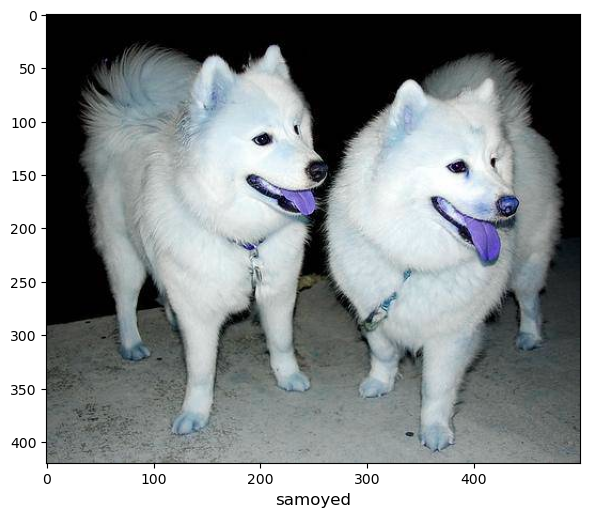

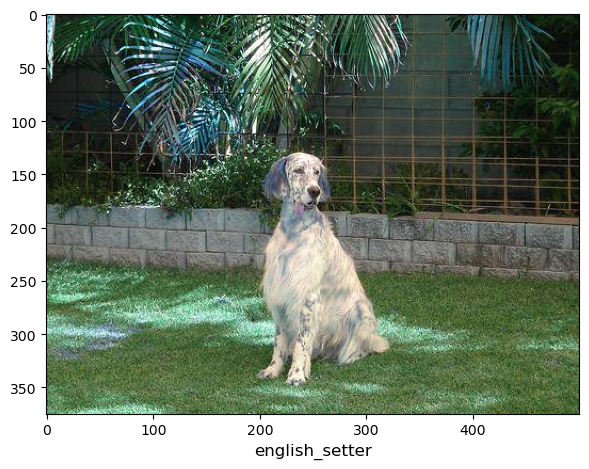

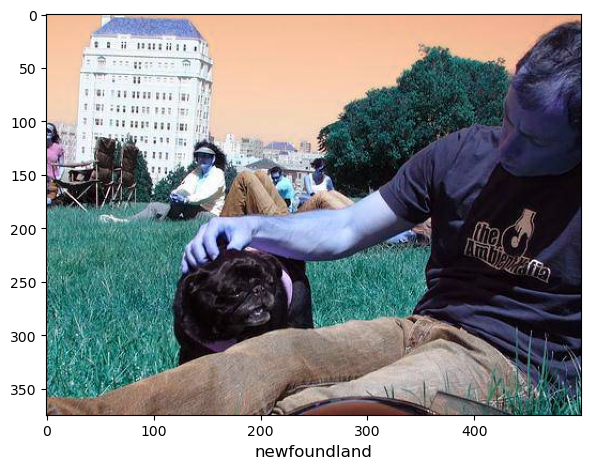

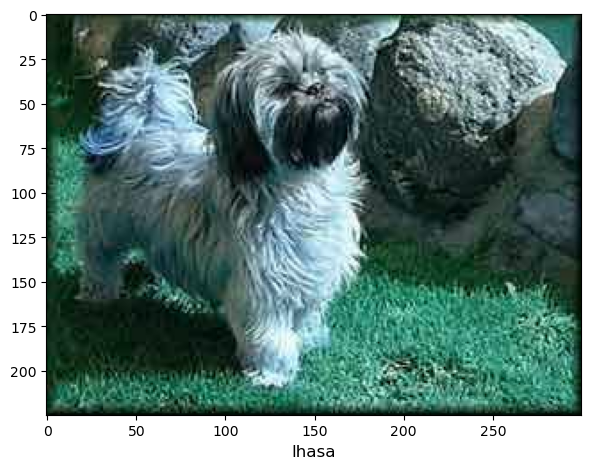

In [36]:
plt.figure(figsize=(6,6))
for index , data in test_dataframe[1:5].iterrows():
    img = data['file_name']
    label = data['breed']
    img = cv2.imread(img)
#     plt.subplot(2,5, index+1)
    plt.imshow(img)
    plt.xlabel(label,fontsize = (12))
    plt.tight_layout()
    plt.show()

In [37]:
!pip install gradio

In [38]:
import gradio as gr

from gradio import Image as image
from gradio import Label as label


In [39]:
def predict_image(img):
  img_4d=img.reshape(-1,180,180,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(5)}
     